In [1]:
import pandas as pd
from clearml import Task
from clearml.backend_api.session.client import APIClient
import numpy as np
import h5py
import os
from pathlib import Path
import re
from datetime import datetime
import dask.dataframe as dd
import gc
import pyarrow.parquet as pq
import pyarrow as pa

def find_latest_h5_file(task_id, base_dir="/scratch/clearml/offline_logs/"):
    """Find the latest h5 file for a given task_id"""
    base_path = Path(base_dir)
    
    pattern = f"metrics_{task_id}*.h5"
    matching_files = list(base_path.glob(pattern))
    
    if not matching_files:
        print(f"  No h5 file found for task {task_id}")
        return None
    
    if len(matching_files) == 1:
        # print(f"  Found h5 file: {matching_files[0].name}")
        return matching_files[0]
    
    files_with_timestamps = []
    for file_path in matching_files:
        filename = file_path.name
        timestamp_match = re.search(f"metrics_{task_id}_(.+)\\.h5", filename)
        if timestamp_match:
            timestamp_str = timestamp_match.group(1)
            try:
                timestamp = float(timestamp_str)
            except ValueError:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S").timestamp()
                except:
                    timestamp = float('-inf')
            files_with_timestamps.append((file_path, timestamp))
        else:
            files_with_timestamps.append((file_path, float('-inf')))
    
    latest_file = max(files_with_timestamps, key=lambda x: x[1])[0]
    # print(f"  Multiple h5 files found, using latest: {latest_file.name}")
    return latest_file

def debug_h5_structure(h5_path):
    """Debug function to inspect h5 file structure"""
    print(f"\nDEBUGGING H5 FILE: {h5_path}")
    
    with h5py.File(h5_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Dtype: {obj.dtype}")
                if obj.size < 10:
                    print(f"  Data preview: {obj[:]}")
                else:
                    print(f"  Data preview (first 5): {obj[:5]}")
        
        print("H5 File Structure:")
        f.visititems(print_structure)
        print(f"\nRoot level keys: {list(f.keys())}")

def read_h5_metrics(h5_path):
    """Read metrics from h5 file and return as structured dictionary"""
    metrics = {}
    
    with h5py.File(h5_path, 'r') as f:
        metric_names = set()
        for key in f.keys():
            if not key.endswith('_iterations'):
                metric_names.add(key)
        
        for metric_name in metric_names:
            iteration_key = f"{metric_name}_iterations"
            
            if metric_name in f:
                values = f[metric_name][:]
                iterations = f[iteration_key][:] if iteration_key in f else None
                
                metrics[metric_name] = {
                    'values': values,
                    'iterations': iterations
                }
    
    return metrics

def download_and_process_tasks_from_h5_normalized(tags, experiment_name, base_dir="/scratch/clearml/offline_logs/", 
                                                   debug_first=True, batch_size=20, 
                                                   metadata_path=None, timeseries_path=None, force_download=False,
                                                   project_name="oho",
                                                   parameter_filters=None): # <--- 1. NEW ARGUMENT
    """
    Download tasks and save as normalized tables: metadata + timeseries.
    parameter_filters: Dict of {param_name: expected_value} to filter tasks.
    """
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tags}")
    
    if not metadata_path or not timeseries_path:
        raise ValueError("Both metadata_path and timeseries_path are required")
    
    # Check if files already exist
    if not force_download and os.path.exists(metadata_path) and os.path.exists(timeseries_path):
        print(f"\nFound existing files:")
        print(f"  Metadata: {metadata_path}")
        print(f"  Timeseries: {timeseries_path}")
        print(f"Loading as Dask DataFrames...")
        
        df_metadata = dd.read_parquet(metadata_path)
        df_timeseries = dd.read_parquet(timeseries_path)
        
        return df_metadata, df_timeseries
    
    if force_download:
        print("Force download enabled - will regenerate files")
    
    print(f"Will save metadata to: {metadata_path}")
    print(f"Will save timeseries to: {timeseries_path}")
    
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    os.makedirs(os.path.dirname(timeseries_path), exist_ok=True)
    
    # Remove existing files
    if os.path.exists(metadata_path):
        os.remove(metadata_path)
    if os.path.exists(timeseries_path):
        os.remove(timeseries_path)
    
    # Initialize API client
    client = APIClient()
    
    # Get project ID
    if isinstance(project_name, str):
        projects = client.projects.get_all(name=project_name)
        if not projects:
            raise ValueError(f"Project '{project_name}' not found")
        project_id = projects[0].id
        print(f"Found project ID: {project_id}")
    else:
        project_id = project_name
    
    h5_files_found = 0
    h5_files_missing = 0
    total_metadata_rows = 0
    total_timeseries_rows = 0
    total_tasks_processed = 0
    
    metadata_rows = []
    timeseries_writer = None
    
    page_size = batch_size
    page = 0
    first_h5_debugged = False
    
    target_params = ["learning_rate", "optimizer/_type", "seed/global_seed", "weight_decay", "momentum"]

    while True:
        print(f"\n=== FETCHING PAGE {page} (size={page_size}) ===")
        
        api_tasks = client.tasks.get_all(
            project=[project_id],
            tags=tags if isinstance(tags, list) else [tags],
            status=["completed"],
            system_tags=["-archived"],
            order_by=["-created"],
            page=page,
            page_size=page_size,
            only_fields=["id", "name"]
        )
        
        if not api_tasks:
            print("No more tasks found, stopping pagination")
            break
        
        print(f"Processing {len(api_tasks)} tasks from page {page}")
        
        timeseries_rows = []
        
        for idx, api_task in enumerate(api_tasks):
            task_id = api_task.id
            task_name = api_task.name
            
            try:
                full_task = Task.get_task(task_id=task_id)
                all_params = full_task.get_parameters() or {}
            except Exception as e:
                print(f"  Warning: Could not load Task object {task_id}: {e}")
                all_params = {}

            # --- 2. FILTERING LOGIC ---
            if parameter_filters:
                skip_task = False
                for filter_key, filter_val in parameter_filters.items():
                    # If the key isn't in parameters, skip this task
                    if filter_key not in all_params:
                        skip_task = True
                        break
                    
                    actual_val = all_params[filter_key]
                    
                    # Handle comparison (convert strings to floats if filter value is a number)
                    try:
                        if isinstance(filter_val, (int, float)):
                            if float(actual_val) != float(filter_val):
                                skip_task = True
                                break
                        else:
                            if str(actual_val) != str(filter_val):
                                skip_task = True
                                break
                    except ValueError:
                        # Fallback to string comparison if conversion fails
                        if str(actual_val) != str(filter_val):
                            skip_task = True
                            break
                
                if skip_task:
                    # print(f"  Skipping task {task_id} due to filter mismatch")
                    continue
            # --------------------------

            total_tasks_processed += 1
            metadata_row = {"task_id": task_id, "task_name": task_name}
            
            # --- 3. METADATA EXTRACTION (Updated) ---
            # Extract target substrings AND specific filter keys
            for key, value in all_params.items():
                is_target = any(x in key for x in target_params)
                is_filter = parameter_filters and (key in parameter_filters)
                
                if is_target or is_filter:
                    metadata_row[key] = value
            # ----------------------------------------

            h5_path = find_latest_h5_file(task_id, base_dir)
            
            if h5_path is None:
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
                continue
            
            h5_files_found += 1
            
            if debug_first and not first_h5_debugged and h5_files_found == 1:
                debug_h5_structure(h5_path)
                first_h5_debugged = True
            
            try:
                metrics = read_h5_metrics(h5_path)
                
                scalar_metrics = {}
                timeseries_metrics = {}
                
                for metric_name, metric_data in metrics.items():
                    values = metric_data['values']
                    iterations = metric_data['iterations']
                    
                    if metric_name.startswith('final_'):
                        scalar_metrics[f"metric/{metric_name}"] = values[0] if len(values) > 0 else np.nan
                    elif iterations is not None and len(values) == len(iterations):
                        timeseries_metrics[metric_name] = metric_data
                
                metadata_row.update(scalar_metrics)
                metadata_rows.append(metadata_row)
                
                if timeseries_metrics:
                    ref_metric = list(timeseries_metrics.keys())[0]
                    iterations = timeseries_metrics[ref_metric]['iterations']
                    
                    for iter_idx, iteration in enumerate(iterations):
                        ts_row = {
                            "task_id": task_id,
                            "iteration": int(iteration)
                        }
                        
                        for metric_name, metric_data in timeseries_metrics.items():
                            if iter_idx < len(metric_data['values']):
                                ts_row[f"metric/{metric_name}"] = metric_data['values'][iter_idx]
                        
                        timeseries_rows.append(ts_row)
                
                del metrics
                del scalar_metrics
                del timeseries_metrics
                    
            except Exception as e:
                print(f"  ERROR reading h5 file: {e}")
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
        
        if timeseries_rows:
            ts_batch_df = pd.DataFrame(timeseries_rows)
            total_timeseries_rows += len(ts_batch_df)
            
            if page == 0:
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer = pq.ParquetWriter(timeseries_path, ts_table.schema)
                timeseries_writer.write_table(ts_table)
            else:
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer.write_table(ts_table)
            
            print(f"  Saved timeseries batch ({len(ts_batch_df)} rows)")
            del timeseries_rows
            del ts_batch_df
            del ts_table
            gc.collect()
        
        if len(metadata_rows) >= 100:
            print(f"  Saving intermediate metadata batch ({len(metadata_rows)} rows)")
            if os.path.exists(metadata_path):
                existing_df = pd.read_parquet(metadata_path)
                combined_df = pd.concat([existing_df, pd.DataFrame(metadata_rows)], ignore_index=True)
                combined_df.to_parquet(metadata_path, index=False)
                del existing_df
                del combined_df
            else:
                pd.DataFrame(metadata_rows).to_parquet(metadata_path, index=False)
            
            total_metadata_rows += len(metadata_rows)
            metadata_rows = []
            gc.collect()
        
        print(f"  Progress: {total_tasks_processed} tasks processed (post-filter), {h5_files_found} h5 files found")
        
        page += 1
        
        if page > 1000:
            print("WARNING: Reached maximum page limit, stopping")
            break
    
    if timeseries_writer is not None:
        timeseries_writer.close()
    
    if metadata_rows:
        if os.path.exists(metadata_path):
            existing_df = pd.read_parquet(metadata_path)
            combined_df = pd.concat([existing_df, pd.DataFrame(metadata_rows)], ignore_index=True)
            combined_df.to_parquet(metadata_path, index=False)
        else:
            pd.DataFrame(metadata_rows).to_parquet(metadata_path, index=False)
        
        total_metadata_rows += len(metadata_rows)
        print(f"\nSaved final metadata batch ({len(metadata_rows)} rows)")
        del metadata_rows
        gc.collect()
    
    print(f"\n=== SUMMARY ===")
    print(f"Total tasks (matched filters): {total_tasks_processed}")
    print(f"H5 files found: {h5_files_found}")
    print(f"H5 files missing: {h5_files_missing}")
    print(f"Total metadata rows: {total_metadata_rows}")
    print(f"Total timeseries rows: {total_timeseries_rows}")
    
    print(f"\nLoading as Dask DataFrames")
    df_metadata = dd.read_parquet(metadata_path)
    df_timeseries = dd.read_parquet(timeseries_path)
    
    return df_metadata, df_timeseries

In [2]:

# Usage
df_metadata_mu_exp, df_timeseries_mu_exp = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 704d6ff61f0f41ba91e869bbef2cbc65", "opt: 4424acdec7e2462d8b65831f76fa5618"], 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/mu_exp_metadata.parquet",
    timeseries_path="/scratch/clearml/processed_data/mu_exp_timeseries.parquet",
    force_download=False,
)


DOWNLOADING TASKS FOR Fixed LR: ['opt: 704d6ff61f0f41ba91e869bbef2cbc65', 'opt: 4424acdec7e2462d8b65831f76fa5618']

Found existing files:
  Metadata: /scratch/clearml/processed_data/mu_exp_metadata.parquet
  Timeseries: /scratch/clearml/processed_data/mu_exp_timeseries.parquet
Loading as Dask DataFrames...



Processing mu_exp...
Found 4 unique momentum values: ['0.0', '0.1', '0.5', '0.9']
Momentum 0.0: 6 tasks, mean=2.0302, std=0.3154
Momentum 0.1: 20 tasks, mean=1.5378, std=0.1773
Momentum 0.5: 19 tasks, mean=1.5283, std=0.0624
Momentum 0.9: 20 tasks, mean=1.4872, std=0.0124


/tmp/ipykernel_442/3237275013.py:37: UserWarning: `meta` is not specified, inferred from partial data.
Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result

  grouped = df_metadata.groupby(momentum_col)['metric/final_test_loss'].apply(list).compute()



PDF saved to: mu_exp_momentum_grouped_violin_plot.pdf


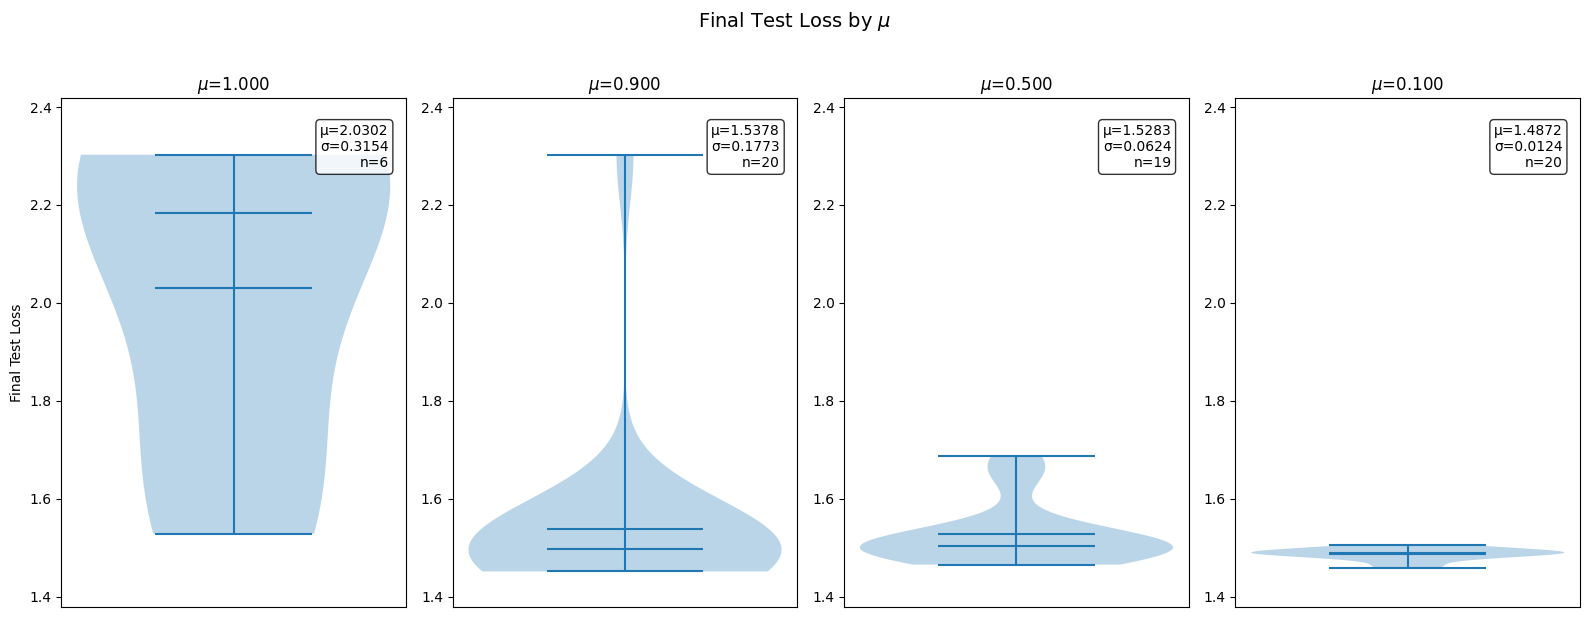

In [4]:
import matplotlib.pyplot as plt
import matplotlib # Added
import numpy as np

# === THE FIX FOR EDITABLE TEXT (Type 42) === # Added
# This setting embeds TrueType fonts, keeping text as text objects.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Optional: Add common fonts for better editing compatibility # Added
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']


def plot_momentum_grouped_violins(experiment):
    """
    Plot violin plots for final test loss grouped by momentum values.
    Creates a single row of violin plots, one for each momentum value.
    Saves the plot as an editable PDF.
    """
    
    name, df_metadata, df_timeseries = experiment
    
    print(f"\n{'='*60}")
    print(f"Processing {name}...")
    print(f"{'='*60}")
    
    momentum_col = 'config/learners/1/learner/momentum1'
    
    # Check if momentum column exists
    if momentum_col not in df_metadata.columns:
        print(f"Error: Momentum column '{momentum_col}' not found")
        return
    
    # Group by momentum and get final test losses
    # Assuming df_metadata is a Dask DataFrame
    grouped = df_metadata.groupby(momentum_col)['metric/final_test_loss'].apply(list).compute()
    
    # Get unique momentum values sorted
    momentum_values = sorted(grouped.index.tolist())
    n_groups = len(momentum_values)
    
    print(f"Found {n_groups} unique momentum values: {momentum_values}")
    
    # Prepare data for violin plots
    data_for_violins = []
    labels = []
    
    for momentum in momentum_values:
        losses = [l for l in grouped[momentum] if not np.isnan(l)]
        data_for_violins.append(losses)
        # Handle both string and float momentum values
        if isinstance(momentum, str):
            momentum_val = float(momentum)
            labels.append(f"$\\mu$={1-momentum_val:.3f}")
            print(f"Momentum {momentum}: {len(losses)} tasks, "
                  f"mean={np.mean(losses):.4f}, std={np.std(losses):.4f}")
        else:
            labels.append(f"$\\mu$={1-momentum:.3f}")
            print(f"Momentum {momentum:.3f}: {len(losses)} tasks, "
                  f"mean={np.mean(losses):.4f}, std={np.std(losses):.4f}")
    
    # Create single row of violin plots
    fig, axes = plt.subplots(1, n_groups, figsize=(4 * n_groups, 6))
    if n_groups == 1:
        axes = [axes]
    
    # Calculate shared y-axis limits
    all_losses = [loss for group in data_for_violins for loss in group]
    ylim = (min(all_losses) * 0.95, max(all_losses) * 1.05)
    
    for i, (data, label) in enumerate(zip(data_for_violins, labels)):
        axes[i].violinplot([data], positions=[0], showmeans=True, showmedians=True)
        mean_val, std_val = np.mean(data), np.std(data)
        axes[i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}\nn={len(data)}', 
                     transform=axes[i].transAxes, va='top', ha='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[i].set_title(label)
        axes[i].set_ylabel("Final Test Loss" if i == 0 else "")
        axes[i].set_xticks([])
        axes[i].set_ylim(ylim)
    
    fig.suptitle(r"Final Test Loss by $\mu$", fontsize=14, y=1.02)
    plt.tight_layout()
    
    # === PDF Saving Logic (The only change requested) ===
    output_path = f'{name}_momentum_grouped_violin_plot.pdf'
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPDF saved to: {output_path}")
    
    plt.show()

plot_momentum_grouped_violins(("mu_exp", df_metadata_mu_exp, df_timeseries_mu_exp))

In [2]:
# Usage
df_metadata_exp1, df_timeseries_exp1 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 32040bae05324bd1b8485960dbfd64db"], 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,  # This now controls pagination size (was 20 before, you had fetch_batch_size=50)
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata_32040bae05324bd1b8485960dbfd64db.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries_32040bae05324bd1b8485960dbfd64db.parquet",
    force_download=False,
    project_name="oho"  # Optional, defaults to "oho"
)

DOWNLOADING TASKS FOR Fixed LR: ['opt: 32040bae05324bd1b8485960dbfd64db']

Found existing files:
  Metadata: /scratch/clearml/processed_data/fixed_lr_metadata_32040bae05324bd1b8485960dbfd64db.parquet
  Timeseries: /scratch/clearml/processed_data/fixed_lr_timeseries_32040bae05324bd1b8485960dbfd64db.parquet
Loading as Dask DataFrames...


In [3]:




# Usage
df_metadata_exp2, df_timeseries_exp2 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 704d6ff61f0f41ba91e869bbef2cbc65", "opt: 4424acdec7e2462d8b65831f76fa5618"], 
    experiment_name="OHO",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,  # This now controls pagination size (was 20 before, you had fetch_batch_size=50)
    metadata_path="/scratch/clearml/processed_data/metadata_oho_figures.parquet",
    timeseries_path="/scratch/clearml/processed_data/timeseries_oho_figures.parquet",
    force_download=False,
    project_name="oho",
    parameter_filters={
        'config/learners/1/learner/momentum1': 0.9
    },
)


DOWNLOADING TASKS FOR OHO: ['opt: 704d6ff61f0f41ba91e869bbef2cbc65', 'opt: 4424acdec7e2462d8b65831f76fa5618']

Found existing files:
  Metadata: /scratch/clearml/processed_data/metadata_oho_figures.parquet
  Timeseries: /scratch/clearml/processed_data/timeseries_oho_figures.parquet
Loading as Dask DataFrames...


In [4]:
# Usage
df_metadata_exp3, df_timeseries_exp3 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 80f7a8c037a648459a07d2c9cca734ec"], 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,  # This now controls pagination size (was 20 before, you had fetch_batch_size=50)
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata_80f7a8c037a648459a07d2c9cca734ec.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries_80f7a8c037a648459a07d2c9cca734ec.parquet",
    force_download=False,
    project_name="oho"  # Optional, defaults to "oho"
)

DOWNLOADING TASKS FOR Fixed LR: ['opt: 80f7a8c037a648459a07d2c9cca734ec']
Will save metadata to: /scratch/clearml/processed_data/fixed_lr_metadata_80f7a8c037a648459a07d2c9cca734ec.parquet
Will save timeseries to: /scratch/clearml/processed_data/fixed_lr_timeseries_80f7a8c037a648459a07d2c9cca734ec.parquet
Found project ID: f759fa7bd0574af6be5c045ac6929c08

=== FETCHING PAGE 0 (size=20) ===
Processing 20 tasks from page 0

DEBUGGING H5 FILE: /scratch/clearml/offline_logs/metrics_2da7ebffc01a400788e25a2bad351a62_20251213_214010.h5
H5 File Structure:
Dataset: final_test_accuracy
  Shape: (1,)
  Dtype: float64
  Data preview: [0.49716672]
Dataset: final_test_accuracy_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [10000]
Dataset: final_test_loss
  Shape: (1,)
  Dtype: float64
  Data preview: [1.41375804]
Dataset: final_test_loss_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [10000]
Dataset: meta_gradient_norm
  Shape: (10000,)
  Dtype: float64
  Data preview (first 5): [0

In [5]:
# Usage
df_metadata_exp4, df_timeseries_exp4 = download_and_process_tasks_from_h5_normalized(
    tags=["opt: 1c40dfdf95e54bd29eda787981bfc164"], 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,  # This now controls pagination size (was 20 before, you had fetch_batch_size=50)
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata_1c40dfdf95e54bd29eda787981bfc164.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries_1c40dfdf95e54bd29eda787981bfc164.parquet",
    force_download=False,
    project_name="oho"  # Optional, defaults to "oho"
)

DOWNLOADING TASKS FOR Fixed LR: ['opt: 1c40dfdf95e54bd29eda787981bfc164']
Will save metadata to: /scratch/clearml/processed_data/fixed_lr_metadata_1c40dfdf95e54bd29eda787981bfc164.parquet
Will save timeseries to: /scratch/clearml/processed_data/fixed_lr_timeseries_1c40dfdf95e54bd29eda787981bfc164.parquet
Found project ID: f759fa7bd0574af6be5c045ac6929c08

=== FETCHING PAGE 0 (size=20) ===
Processing 20 tasks from page 0

DEBUGGING H5 FILE: /scratch/clearml/offline_logs/metrics_b30b1863e75e4a0d865ec5b688a73be2_20251215_110224.h5
H5 File Structure:
Dataset: final_test_accuracy
  Shape: (1,)
  Dtype: float64
  Data preview: [0.25883335]
Dataset: final_test_accuracy_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [10000]
Dataset: final_test_loss
  Shape: (1,)
  Dtype: float64
  Data preview: [2.04995275]
Dataset: final_test_loss_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [10000]
Dataset: meta_gradient_norm
  Shape: (10000,)
  Dtype: float64
  Data preview (first 5): [0

In [6]:
# Usage
experiments = [
    ("Fixed LR Vanilla", df_metadata_exp1, df_timeseries_exp1),
    ("OHO Vanilla", df_metadata_exp2, df_timeseries_exp2),
]

In [15]:
# Usage
all_experiments = [
    ("Fixed LR Vanilla", df_metadata_exp1, df_timeseries_exp1),
    ("OHO Vanilla", df_metadata_exp2, df_timeseries_exp2),
    ("Fixed LR GRU", df_metadata_exp4, df_timeseries_exp4),
    ("OHO GRU", df_metadata_exp3, df_timeseries_exp3),
]

In [13]:
# Usage
gru_experiments = [
    ("Fixed LR GRU", df_metadata_exp4, df_timeseries_exp4),
    ("OHO GRU", df_metadata_exp3, df_timeseries_exp3),
]


Processing Fixed LR Vanilla...
Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']

All configurations ranked by mean final test loss (aggregated across seeds):
--------------------------------------------------------------------------------
Rank 1: learning_rate=0.152500, learning_rate=0.000100, weight_decay=0.003344 | mean=1.557237, std=0.023672, n_seeds=20
Rank 2: learning_rate=0.078750, learning_rate=0.000100, weight_decay=0.003344 | mean=1.558058, std=0.021772, n_seeds=20
Rank 3: learning_rate=0.115625, learning_rate=0.000100, weight_decay=0.003344 | mean=1.562424, std=0.034065, n_seeds=20
Rank 4: learning_rate=0.189375, learning_rate=0.000100, weight_decay=0.003344 | mean=1.567985, std=0.036381, n_seeds=20
Rank 5: learning_rate=0.226250, learning_rate=0.000100, weight_decay=0.003344 | mean=1.583037, std=0.024915, n_seeds=20
Rank 6: learning_rate=0.041

  Processed 10/20 tasks
  Processed 20/20 tasks

Best config statistics:
  Final losses: 20 tasks
  Effective LRs: 20 tasks
  Asymptotes: 20 tasks

Processing OHO Vanilla...
Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']

All configurations ranked by mean final test loss (aggregated across seeds):
--------------------------------------------------------------------------------
Rank 1: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010 | mean=1.487182, std=0.012724, n_seeds=20

********************************************************************************
BEST CONFIG: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
Mean final test loss: 1.487182
Number of seeds: 20
********************************************************************************

Processing 20 tasks (seeds) for effective learning rate...
  Proces

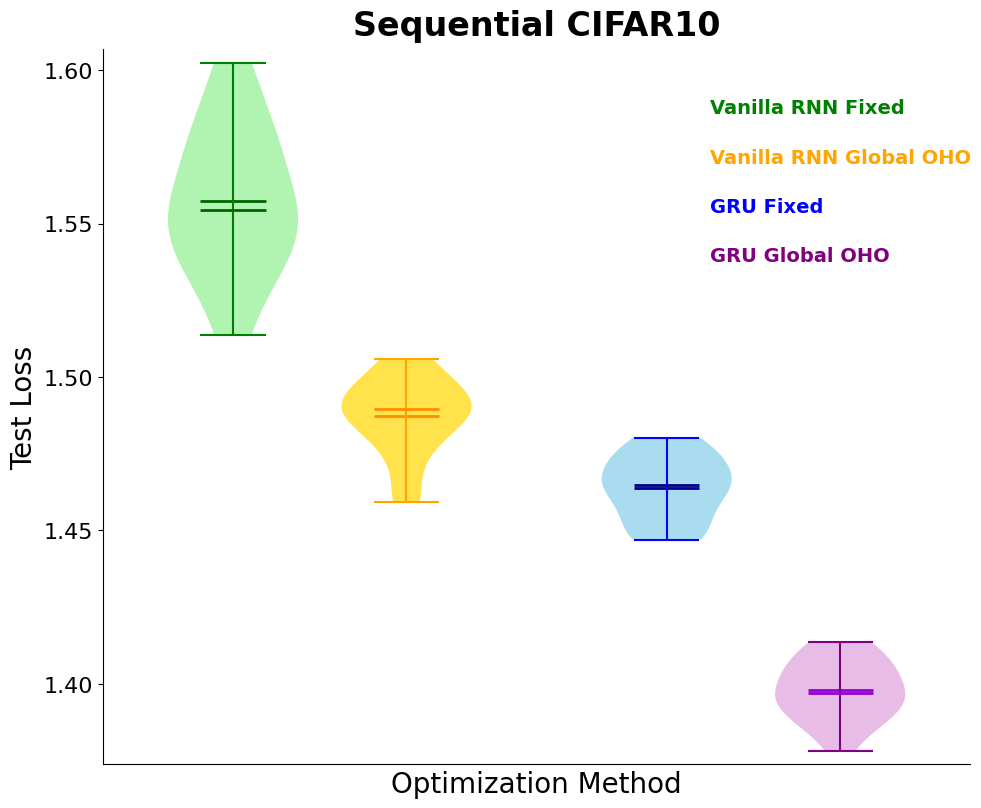

[{'name': 'Fixed LR Vanilla',
  'config': 'learning_rate=0.152500, learning_rate=0.000100, weight_decay=0.003344',
  'final_losses': array([1.55264699, 1.57984245, 1.56264651, 1.60238945, 1.53299522,
         1.53748226, 1.59584844, 1.57007849, 1.53914583, 1.5414995 ,
         1.55466413, 1.55418718, 1.52174628, 1.5751754 , 1.54202735,
         1.57504857, 1.55617726, 1.58510602, 1.55225229, 1.5137707 ]),
  'eff_lrs': array([0.06956507, 0.0702879 , 0.06992079, 0.07033084, 0.07116983,
         0.0720408 , 0.07055735, 0.07136955, 0.07082786, 0.06964505,
         0.06927539, 0.07202927, 0.07231145, 0.07559985, 0.07303217,
         0.07252749, 0.06957723, 0.0711878 , 0.07197617, 0.06954033]),
  'asymptotes': array([4.06799209e-08, 1.23742787e-14, 4.60705309e-11, 3.00922608e-10,
         1.51572904e-09, 6.61270674e-10, 6.36065738e-16, 1.40609051e-17,
         7.07861414e-20, 1.00573313e-08, 3.26163737e-10, 1.91802907e-15,
         1.63751371e-14, 2.18701613e-01, 2.44930257e-09, 1.14415233e-

In [21]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
import os

# === THE FIX FOR EDITABLE TEXT (Type 42) ===
# This setting embeds TrueType fonts, keeping text as text objects.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Optional: Add common fonts for better editing compatibility
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_final_loss_and_effective_lr_violins(experiments):
    """
    Modified to create a single plot with four violin plots side by side.
    Only uses tasks from the BEST configuration based on learning rate, meta learning rate, weight decay, and momentum.
    """
    n_experiments = len(experiments)
    
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\n{'='*60}")
        print(f"Processing {name}...")
        print(f"{'='*60}")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"Using configuration columns: {available_cols}")
        
        # Group by config and get mean final test loss
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        
        print(f"\nAll configurations ranked by mean final test loss (aggregated across seeds):")
        print("-" * 80)
        for rank, (_, row) in enumerate(config_summary.iterrows(), start=1):
            config_str = ", ".join([f"{col.split('/')[-2]}={float(row[col]):.6f}" for col in available_cols])
            print(f"Rank {rank}: {config_str} | "
                f"mean={row['mean']:.6f}, std={row['std']:.6f}, n_seeds={int(row['count'])}")
        
        # Best config is the one with LOWEST mean final test loss
        best_config = config_summary.iloc[0]
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        
        print(f"\n{'*'*80}")
        print(f"BEST CONFIG: {config_str}")
        print(f"Mean final test loss: {best_config['mean']:.6f}")
        print(f"Number of seeds: {int(best_config['count'])}")
        print(f"{'*'*80}")
        
        # Filter metadata to best config
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
        
        # Get final test losses for best config
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        print(f"\nProcessing {len(best_task_ids)} tasks (seeds) for effective learning rate...")
        
        # Compute effective learning rates and asymptotes
        eff_lrs = []
        asymptotes = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
            
            for task_id in chunk_ids:
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])
                            asymptotes.append(popt[2])
                    except:
                        continue
            
            print(f"  Processed {min(i+chunk_size, len(best_task_ids))}/{len(best_task_ids)} tasks")
        
        eff_lrs = np.array(eff_lrs)
        asymptotes = np.array(asymptotes)
        
        experiment_data.append({
            'name': name,
            'config': config_str,
            'final_losses': final_losses,
            'eff_lrs': eff_lrs,
            'asymptotes': asymptotes
        })
        
        print(f"\nBest config statistics:")
        print(f"  Final losses: {len(final_losses)} tasks")
        print(f"  Effective LRs: {len(eff_lrs)} tasks")
        print(f"  Asymptotes: {len(asymptotes)} tasks")
    
    # Create single plot with four violin plots side by side
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Extract data for the four experiments
    exp1_losses = experiment_data[0]['final_losses']  # Vanilla RNN Fixed
    exp2_losses = experiment_data[1]['final_losses']  # Vanilla RNN OHO
    exp3_losses = experiment_data[2]['final_losses']  # GRU Fixed
    exp4_losses = experiment_data[3]['final_losses']  # GRU OHO
    
    # Create violin plots with spacing
    positions = [0.8, 1.2, 1.8, 2.2]
    violin_parts1 = ax.violinplot([exp1_losses], positions=[positions[0]], widths=0.3, 
                                  showmeans=True, showmedians=True)
    violin_parts2 = ax.violinplot([exp2_losses], positions=[positions[1]], widths=0.3,
                                  showmeans=True, showmedians=True)
    violin_parts3 = ax.violinplot([exp3_losses], positions=[positions[2]], widths=0.3,
                                  showmeans=True, showmedians=True)
    violin_parts4 = ax.violinplot([exp4_losses], positions=[positions[3]], widths=0.3,
                                  showmeans=True, showmedians=True)
    
    # Color the first violin plot (Vanilla RNN Fixed) green
    for pc in violin_parts1['bodies']:
        pc.set_facecolor('#90EE90')
        pc.set_alpha(0.7)
    for part in ['cbars', 'cmins', 'cmaxes']:
        if part in violin_parts1:
            vp = violin_parts1[part]
            vp.set_edgecolor('green')
            vp.set_linewidth(1.5)
    if 'cmedians' in violin_parts1:
        violin_parts1['cmedians'].set_edgecolor('darkgreen')
        violin_parts1['cmedians'].set_linewidth(2)
    if 'cmeans' in violin_parts1:
        violin_parts1['cmeans'].set_edgecolor('darkgreen')
        violin_parts1['cmeans'].set_linewidth(2)
    
    # Color the second violin plot (Vanilla RNN OHO) orange
    for pc in violin_parts2['bodies']:
        pc.set_facecolor('#FFD700')
        pc.set_alpha(0.7)
    for part in ['cbars', 'cmins', 'cmaxes']:
        if part in violin_parts2:
            vp = violin_parts2[part]
            vp.set_edgecolor('orange')
            vp.set_linewidth(1.5)
    if 'cmedians' in violin_parts2:
        violin_parts2['cmedians'].set_edgecolor('darkorange')
        violin_parts2['cmedians'].set_linewidth(2)
    if 'cmeans' in violin_parts2:
        violin_parts2['cmeans'].set_edgecolor('darkorange')
        violin_parts2['cmeans'].set_linewidth(2)
    
    # Color the third violin plot (GRU Fixed) blue
    for pc in violin_parts3['bodies']:
        pc.set_facecolor('#87CEEB')  # Sky blue
        pc.set_alpha(0.7)
    for part in ['cbars', 'cmins', 'cmaxes']:
        if part in violin_parts3:
            vp = violin_parts3[part]
            vp.set_edgecolor('blue')
            vp.set_linewidth(1.5)
    if 'cmedians' in violin_parts3:
        violin_parts3['cmedians'].set_edgecolor('darkblue')
        violin_parts3['cmedians'].set_linewidth(2)
    if 'cmeans' in violin_parts3:
        violin_parts3['cmeans'].set_edgecolor('darkblue')
        violin_parts3['cmeans'].set_linewidth(2)
    
    # Color the fourth violin plot (GRU OHO) purple
    for pc in violin_parts4['bodies']:
        pc.set_facecolor('#DDA0DD')  # Plum
        pc.set_alpha(0.7)
    for part in ['cbars', 'cmins', 'cmaxes']:
        if part in violin_parts4:
            vp = violin_parts4[part]
            vp.set_edgecolor('purple')
            vp.set_linewidth(1.5)
    if 'cmedians' in violin_parts4:
        violin_parts4['cmedians'].set_edgecolor('darkviolet')
        violin_parts4['cmedians'].set_linewidth(2)
    if 'cmeans' in violin_parts4:
        violin_parts4['cmeans'].set_edgecolor('darkviolet')
        violin_parts4['cmeans'].set_linewidth(2)
    
    # Set labels and title
    ax.set_title('Sequential CIFAR10', fontsize=24, fontweight='bold', pad=10)
    ax.set_ylabel('Test Loss', fontsize=20)
    ax.set_xlabel('Optimization Method', fontsize=20)
    
    # Remove ALL x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-axis limits with minimal white space
    y_min = min(min(exp1_losses), min(exp2_losses), min(exp3_losses), min(exp4_losses))
    y_max = max(max(exp1_losses), max(exp2_losses), max(exp3_losses), max(exp4_losses))
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.02 * y_range, y_max + 0.02 * y_range)
    
    # Set x-axis limits to reduce horizontal white space
    ax.set_xlim(0.5, 2.5)
    
    # Add ALL colored text labels stacked vertically with smaller font and even tighter spacing
    y_top = ax.get_ylim()[1]
    
    # All four labels stacked vertically with minimal spacing and smaller font, shifted more left
    shift = 1.9
    ax.text(shift, y_top * 0.99, 'Vanilla RNN Fixed', 
            fontsize=14, color='green', fontweight='bold',
            ha='left', va='top')
    ax.text(shift, y_top * 0.98, 'Vanilla RNN Global OHO', 
            fontsize=14, color='orange', fontweight='bold',
            ha='left', va='top')
    ax.text(shift, y_top * 0.97, 'GRU Fixed', 
            fontsize=14, color='blue', fontweight='bold',
            ha='left', va='top')
    ax.text(shift, y_top * 0.96, 'GRU Global OHO', 
            fontsize=14, color='purple', fontweight='bold',
            ha='left', va='top')
    
    # Scale y-tick font size
    ax.tick_params(axis='y', labelsize=16)
    
    # Remove grid
    ax.grid(False)
    
    # Tight layout with minimal padding
    plt.tight_layout(pad=0.4)
    
    # Save as editable PDF using matplotlib's native savefig
    output_path = 'sequential_cifar10_violin_plot.pdf'
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    
    print(f"\nPDF saved to: {output_path}")
    
    # Also show the plot
    plt.show()
    
    return experiment_data

# If you want to use this directly with your experiments variable:
plot_final_loss_and_effective_lr_violins(all_experiments)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
import os

# === THE FIX FOR EDITABLE TEXT (Type 42) ===
# This setting embeds TrueType fonts, keeping text as text objects.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Optional: Add common fonts for better editing compatibility
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_final_loss_and_effective_lr_violins_dual(experiments1, experiments2, label1='RNN', label2='GRU'):
    """
    Modified to create a single plot with FOUR violin plots.
    Takes two experiment sets, each containing Fixed and Global OHO experiments.
    """
    
    def process_experiments(experiments, prefix):
        """Helper function to process one set of experiments"""
        experiment_data = []
        
        for name, df_metadata, df_timeseries in experiments:
            print(f"\n{'='*60}")
            print(f"Processing {prefix} - {name}...")
            print(f"{'='*60}")
            
            config_cols = [
                'config/learners/0/optimizer/learning_rate/value',
                'config/learners/1/optimizer/learning_rate/value',
                'config/learners/0/optimizer/weight_decay/value',
            ]
            
            # Check which columns exist
            available_cols = [col for col in config_cols if col in df_metadata.columns]
            
            if len(available_cols) == 0:
                print(f"Warning: No configuration columns found.")
                continue
            
            print(f"Using configuration columns: {available_cols}")
            
            # Group by config and get mean final test loss
            config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
            config_summary = config_summary.reset_index().sort_values('mean')
            
            print(f"\nAll configurations ranked by mean final test loss (aggregated across seeds):")
            print("-" * 80)
            for rank, (_, row) in enumerate(config_summary.iterrows(), start=1):
                config_str = ", ".join([f"{col.split('/')[-2]}={float(row[col]):.6f}" for col in available_cols])
                print(f"Rank {rank}: {config_str} | "
                    f"mean={row['mean']:.6f}, std={row['std']:.6f}, n_seeds={int(row['count'])}")
            
            # Best config is the one with LOWEST mean final test loss
            best_config = config_summary.iloc[0]
            config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
            
            print(f"\n{'*'*80}")
            print(f"BEST CONFIG: {config_str}")
            print(f"Mean final test loss: {best_config['mean']:.6f}")
            print(f"Number of seeds: {int(best_config['count'])}")
            print(f"{'*'*80}")
            
            # Filter metadata to best config
            mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
            for col in available_cols[1:]:
                mask &= (df_metadata[col] == best_config[col])
            best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
            
            # Get final test losses for best config
            final_losses = best_metadata['metric/final_test_loss'].dropna().values
            best_task_ids = best_metadata['task_id'].values
            
            print(f"\nProcessing {len(best_task_ids)} tasks (seeds) for effective learning rate...")
            
            # Compute effective learning rates and asymptotes
            eff_lrs = []
            asymptotes = []
            chunk_size = 10
            
            for i in range(0, len(best_task_ids), chunk_size):
                chunk_ids = best_task_ids[i:i+chunk_size]
                chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
                
                for task_id in chunk_ids:
                    task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                    if len(task_data) > 5:
                        try:
                            iterations = task_data['iteration'].values
                            test_losses = task_data['metric/test_loss'].dropna().values
                            if len(test_losses) > 5:
                                popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                                  bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                                eff_lrs.append(popt[1])
                                asymptotes.append(popt[2])
                        except:
                            continue
                
                print(f"  Processed {min(i+chunk_size, len(best_task_ids))}/{len(best_task_ids)} tasks")
            
            eff_lrs = np.array(eff_lrs)
            asymptotes = np.array(asymptotes)
            
            experiment_data.append({
                'name': f"{prefix} {name}",
                'config': config_str,
                'final_losses': final_losses,
                'eff_lrs': eff_lrs,
                'asymptotes': asymptotes
            })
            
            print(f"\nBest config statistics:")
            print(f"  Final losses: {len(final_losses)} tasks")
            print(f"  Effective LRs: {len(eff_lrs)} tasks")
            print(f"  Asymptotes: {len(asymptotes)} tasks")
        
        return experiment_data
    
    # Process both experiment sets
    exp1_data = process_experiments(experiments1, label1)
    exp2_data = process_experiments(experiments2, label2)
    
    # Create single plot with FOUR violin plots
    fig, ax = plt.subplots(figsize=(12, 8))  # Wider to accommodate 4 violins
    
    # Set white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Positions for 4 violin plots
    positions = [1, 1.8, 3, 3.8]  # Two pairs with gap between them
    
    # Create violin plots
    violin_parts = []
    
    # Experiments1 - Fixed (green)
    vp1 = ax.violinplot([exp1_data[0]['final_losses']], positions=[positions[0]], widths=0.6,
                         showmeans=True, showmedians=True)
    violin_parts.append(vp1)
    
    # Experiments1 - Global OHO (orange)
    vp2 = ax.violinplot([exp1_data[1]['final_losses']], positions=[positions[1]], widths=0.6,
                         showmeans=True, showmedians=True)
    violin_parts.append(vp2)
    
    # Experiments2 - Fixed (blue)
    vp3 = ax.violinplot([exp2_data[0]['final_losses']], positions=[positions[2]], widths=0.6,
                         showmeans=True, showmedians=True)
    violin_parts.append(vp3)
    
    # Experiments2 - Global OHO (red)
    vp4 = ax.violinplot([exp2_data[1]['final_losses']], positions=[positions[3]], widths=0.6,
                         showmeans=True, showmedians=True)
    violin_parts.append(vp4)
    
    # Colors for each violin
    colors = ['#90EE90', '#FFD700', '#ADD8E6', '#FFB6C1']  # light green, gold, light blue, light red
    edge_colors = ['green', 'orange', 'blue', 'red']
    dark_colors = ['darkgreen', 'darkorange', 'darkblue', 'darkred']
    
    # Style each violin plot
    for i, vp in enumerate(violin_parts):
        # Color the body
        for pc in vp['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
        # Color the parts
        for part in ['cbars', 'cmins', 'cmaxes']:
            if part in vp:
                vp[part].set_edgecolor(edge_colors[i])
                vp[part].set_linewidth(1.5)
        if 'cmedians' in vp:
            vp['cmedians'].set_edgecolor(dark_colors[i])
            vp['cmedians'].set_linewidth(2)
        if 'cmeans' in vp:
            vp['cmeans'].set_edgecolor(dark_colors[i])
            vp['cmeans'].set_linewidth(2)
    
    # Set labels and title
    ax.set_title('Sequential CIFAR10 - Model Comparison', fontsize=24, fontweight='bold', pad=10)
    ax.set_ylabel('Test Loss', fontsize=20)
    
    # Set x-ticks and labels
    ax.set_xticks([(positions[0] + positions[1])/2, (positions[2] + positions[3])/2])
    ax.set_xticklabels([label1, label2], fontsize=18, fontweight='bold')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-axis limits with minimal white space
    all_losses = (list(exp1_data[0]['final_losses']) + list(exp1_data[1]['final_losses']) + 
                  list(exp2_data[0]['final_losses']) + list(exp2_data[1]['final_losses']))
    y_min = min(all_losses)
    y_max = max(all_losses)
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.02 * y_range, y_max + 0.05 * y_range)  # Extra space at top for legend
    
    # Set x-axis limits
    ax.set_xlim(0.3, 4.5)
    
    # Add legend with colored labels
    y_top = ax.get_ylim()[1]
    y_pos = y_top * 0.98
    
    # Legend for experiments1
    ax.text(positions[0], y_pos, f'{label1} Fixed', 
            fontsize=14, color='green', fontweight='bold',
            ha='center', va='top')
    ax.text(positions[1], y_pos, f'{label1} Global OHO', 
            fontsize=14, color='orange', fontweight='bold',
            ha='center', va='top')
    
    # Legend for experiments2
    ax.text(positions[2], y_pos, f'{label2} Fixed', 
            fontsize=14, color='blue', fontweight='bold',
            ha='center', va='top')
    ax.text(positions[3], y_pos, f'{label2} Global OHO', 
            fontsize=14, color='red', fontweight='bold',
            ha='center', va='top')
    
    # Scale y-tick font size
    ax.tick_params(axis='y', labelsize=16)
    
    # Remove grid
    ax.grid(False)
    
    # Add vertical line to separate the two model types
    ax.axvline(x=(positions[1] + positions[2])/2, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Tight layout
    plt.tight_layout(pad=0.4)
    
    # Save as editable PDF
    output_path = 'sequential_cifar10_violin_plot_comparison.pdf'
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    
    print(f"\nPDF saved to: {output_path}")
    
    # Also show the plot
    plt.show()
    
    return exp1_data + exp2_data

# Usage:
# plot_final_loss_and_effective_lr_violins_dual(experiments1, experiments2, label1='RNN', label2='GRU')


Processing Fixed LR...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.152500, learning_rate=0.000100, weight_decay=0.003344
  Mean final test loss: 1.557237
  Number of seeds: 20

Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.001000, weight_decay=0.000010
  Mean final test loss: 1.487182
  Number of seeds: 20


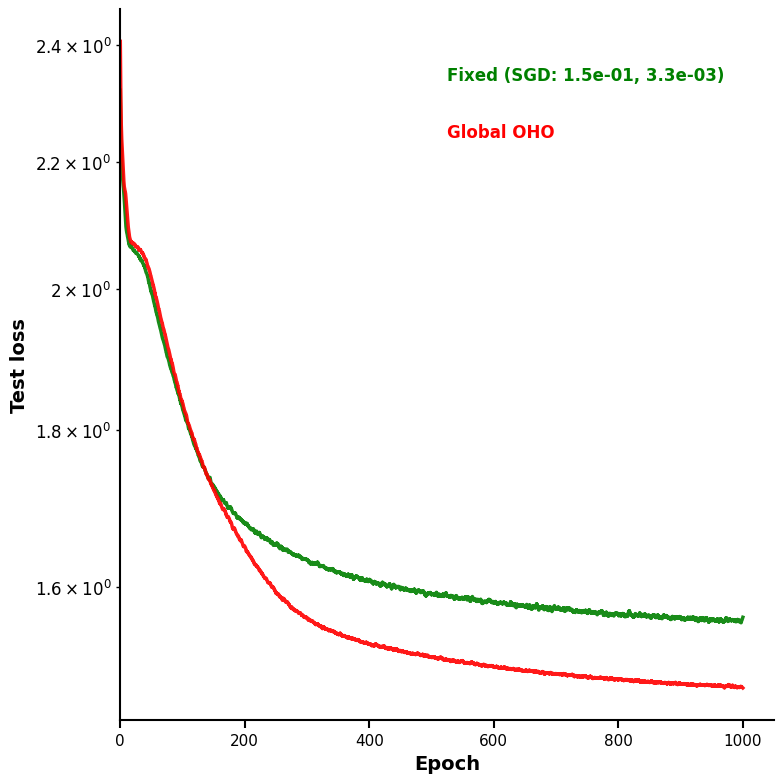


Plot saved to test_loss_curves.pdf


In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
# Removed: from matplotlib.backends.backend_pdf import PdfPages

# === THE FIX FOR EDITABLE TEXT (Type 42) ===
# This setting embeds TrueType fonts, keeping text as text objects.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Optional: Set a common font family like Arial for better compatibility 
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_smooth_test_loss_curves(experiments, save_path='test_loss_curves.pdf'):
    """
    Plot smoothened test loss curves with clean formatting and consistent figure size.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        save_path: path to save the PDF output
    """
    # Set matplotlib parameters for clean publication-ready figures
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['xtick.major.width'] = 1.5
    plt.rcParams['ytick.major.width'] = 1.5
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    
    # --- FIXED: Use same figure size as the violin plot (8, 8) ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Define colors: first green, second red
    colors = ['green', 'red', 'blue', 'purple', 'orange']
    labels_info = []
    
    for idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        color = colors[idx % len(colors)]
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        # Extract learning rate and weight decay for label
        lr = float(best_config[available_cols[0]]) if available_cols[0] in best_config else 0
        wd = float(best_config[available_cols[2]]) if len(available_cols) > 2 and available_cols[2] in best_config else 0
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Mean final test loss: {best_config['mean']:.6f}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id']].compute()
        best_task_ids = best_metadata['task_id'].values
        
        # Get timeseries for best config using Dask
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
        
        # Compute average test loss curve
        avg_curve = best_timeseries.groupby('iteration')['metric/test_loss'].mean()
        iterations = avg_curve.index.values
        avg_test_losses = avg_curve.values
        
        # Convert iterations to epochs (10 iterations per epoch based on context clues)
        epochs = iterations / 10 
        
        # Apply smoothing using Savitzky-Golay filter
        window_length = min(51, len(avg_test_losses))
        if window_length % 2 == 0:
            window_length -= 1
        if window_length >= 5:
            smoothed_losses = savgol_filter(avg_test_losses, window_length, 3)
        else:
            smoothed_losses = avg_test_losses
        
        # Plot smoothed curve
        ax.plot(epochs, smoothed_losses, color=color, linewidth=2.5, alpha=0.9)
        
        # Store label info
        if idx == 0:
            label_text = f'Fixed (SGD: {lr:.1e}, {wd:.1e})'
        else:
            label_text = 'Global OHO'
        labels_info.append((label_text, color))
    
    # Set log scale for y-axis
    ax.set_yscale('log')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set axis labels
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel('Test loss', fontsize=14, fontweight='bold')
    
    # Remove grid for cleaner look
    ax.grid(False)
    
    # Add labels directly on the plot (vertically stacked, color-coded)
    x_pos = 0.5
    y_start = 0.9
    y_spacing = 0.08
    
    for i, (label_text, color) in enumerate(labels_info):
        ax.text(x_pos, y_start - i*y_spacing, label_text, 
                transform=ax.transAxes,
                fontsize=12, 
                color=color,
                fontweight='bold')
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
    ax.tick_params(axis='both', which='minor', width=1, length=3)
    
    # Set x-axis limits if needed
    ax.set_xlim(left=0)
    
    plt.tight_layout()
    
    # Save as editable PDF using the Type 42 setting
    plt.savefig(save_path, 
                format='pdf', 
                bbox_inches='tight', 
                dpi=300)
    
    # Show the plot
    plt.show()
    
    print(f"\nPlot saved to {save_path}")

# Example call (needs 'experiments' variable to run)
plot_smooth_test_loss_curves(experiments, save_path='test_loss_curves.pdf')


Processing Fixed LR GRU...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.189375, learning_rate=0.000100, weight_decay=0.002280
  Mean final test loss: 1.463746
  Number of seeds: 20

Processing OHO GRU...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.000100, weight_decay=0.000010
  Mean final test loss: 1.397968
  Number of seeds: 20


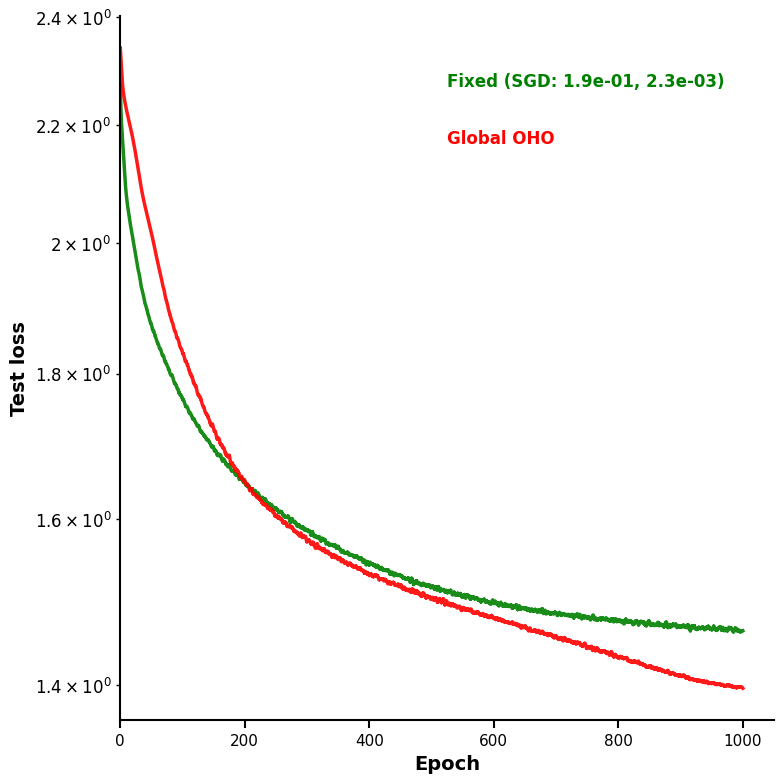


Plot saved to gru_test_loss_curves.pdf


In [22]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
# Removed: from matplotlib.backends.backend_pdf import PdfPages

# === THE FIX FOR EDITABLE TEXT (Type 42) ===
# This setting embeds TrueType fonts, keeping text as text objects.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Optional: Set a common font family like Arial for better compatibility 
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_smooth_test_loss_curves(experiments, save_path='test_loss_curves.pdf'):
    """
    Plot smoothened test loss curves with clean formatting and consistent figure size.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        save_path: path to save the PDF output
    """
    # Set matplotlib parameters for clean publication-ready figures
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['xtick.major.width'] = 1.5
    plt.rcParams['ytick.major.width'] = 1.5
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    
    # --- FIXED: Use same figure size as the violin plot (8, 8) ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Define colors: first green, second red
    colors = ['green', 'red', 'blue', 'purple', 'orange']
    labels_info = []
    
    for idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        color = colors[idx % len(colors)]
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        # Extract learning rate and weight decay for label
        lr = float(best_config[available_cols[0]]) if available_cols[0] in best_config else 0
        wd = float(best_config[available_cols[2]]) if len(available_cols) > 2 and available_cols[2] in best_config else 0
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Mean final test loss: {best_config['mean']:.6f}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id']].compute()
        best_task_ids = best_metadata['task_id'].values
        
        # Get timeseries for best config using Dask
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
        
        # Compute average test loss curve
        avg_curve = best_timeseries.groupby('iteration')['metric/test_loss'].mean()
        iterations = avg_curve.index.values
        avg_test_losses = avg_curve.values
        
        # Convert iterations to epochs (10 iterations per epoch based on context clues)
        epochs = iterations / 10 
        
        # Apply smoothing using Savitzky-Golay filter
        window_length = min(51, len(avg_test_losses))
        if window_length % 2 == 0:
            window_length -= 1
        if window_length >= 5:
            smoothed_losses = savgol_filter(avg_test_losses, window_length, 3)
        else:
            smoothed_losses = avg_test_losses
        
        # Plot smoothed curve
        ax.plot(epochs, smoothed_losses, color=color, linewidth=2.5, alpha=0.9)
        
        # Store label info
        if idx == 0:
            label_text = f'Fixed (SGD: {lr:.1e}, {wd:.1e})'
        else:
            label_text = 'Global OHO'
        labels_info.append((label_text, color))
    
    # Set log scale for y-axis
    ax.set_yscale('log')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set axis labels
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel('Test loss', fontsize=14, fontweight='bold')
    
    # Remove grid for cleaner look
    ax.grid(False)
    
    # Add labels directly on the plot (vertically stacked, color-coded)
    x_pos = 0.5
    y_start = 0.9
    y_spacing = 0.08
    
    for i, (label_text, color) in enumerate(labels_info):
        ax.text(x_pos, y_start - i*y_spacing, label_text, 
                transform=ax.transAxes,
                fontsize=12, 
                color=color,
                fontweight='bold')
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
    ax.tick_params(axis='both', which='minor', width=1, length=3)
    
    # Set x-axis limits if needed
    ax.set_xlim(left=0)
    
    plt.tight_layout()
    
    # Save as editable PDF using the Type 42 setting
    plt.savefig(save_path, 
                format='pdf', 
                bbox_inches='tight', 
                dpi=300)
    
    # Show the plot
    plt.show()
    
    print(f"\nPlot saved to {save_path}")

# Example call (needs 'experiments' variable to run)
plot_smooth_test_loss_curves(gru_experiments, save_path='gru_test_loss_curves.pdf')


Processing Fixed LR...

Processing OHO...

Plot saved as learning_rates.pdf


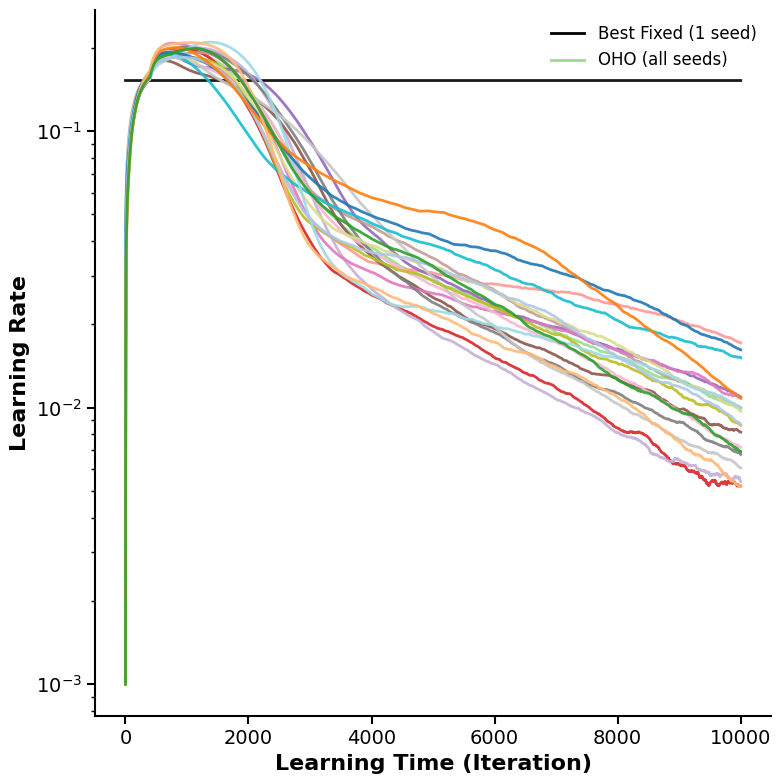

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# === THE FIX ===
# Type 42 fonts are TrueType fonts, which are embedded as text.
# The default is Type 3, which converts text to outlines/paths.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def plot_hyperparameters_for_best_config(experiments, smoothing_window=25, save_path='learning_rates.pdf'):
    """
    Plot learning rates over time with modifications:
    - ONLY ONE best fixed learning rate (black)
    - ALL seeds for other experiments (colored)
    - Log scale y-axis
    - Clean axes (left and bottom only)
    - Save as PDF with EDITABLE TEXT
    - Smoothed lines using a rolling average
    - **Figure size set to (8, 8) for consistency.**
    """
    # Set default font for better consistency (optional but good practice)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

    # Create figure - FIXED SIZE
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Get a colormap
    base_cmap = plt.get_cmap("tab20") 
    
    # Store legend information
    legend_elements = []

    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")

        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
        ]

        available_cols = [col for col in config_cols if col in df_metadata.columns]
        if len(available_cols) == 0:
            print("  Warning: No config columns found.")
            continue

        # --- 1. Identify Best Config ---
        config_summary = (
            df_metadata.groupby(available_cols)['metric/final_test_loss']
            .agg(['mean', 'count'])
            .compute()
        )
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]

        # --- 2. Filter Metadata ---
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        
        best_metadata = df_metadata[mask][[
            'task_id', 'config/seed/global_seed'
        ]].compute()

        best_task_ids = best_metadata['task_id'].values

        # --- 3. Get Time Series Data ---
        best_timeseries = df_timeseries[
            df_timeseries['task_id'].isin(best_task_ids.tolist())
        ][[
            'task_id', 'iteration',
            'metric/train_recurrent_learning_rate'
        ]].compute()

        # Distinct color offset per experiment
        exp_color_offset = (exp_idx * 5) % 20
        
        # Variable to track if we've added the main label
        main_label_added = False

        # --- 4. Plotting Loop ---
        for seed_idx, (_, row) in enumerate(best_metadata.iterrows()):
            task_id = row['task_id']

            # FIRST EXPERIMENT -> only first seed plotted (Fixed LR)
            if exp_idx == 0 and seed_idx > 0:
                continue

            task_data = best_timeseries[best_timeseries['task_id'] == task_id].sort_values('iteration')
            if len(task_data) < 2: # Need at least 2 points for a line/smoothing
                continue

            iterations = task_data['iteration'].values

            # Determine Color and Label
            if exp_idx == 0:
                color = "black"  # FIXED LR = BLACK
                label_text = "Best Fixed (1 seed)"
            else:
                color = base_cmap((exp_color_offset + seed_idx) % 20)
                label_text = name # The name of the experiment (e.g., 'Global OHO')

            # Process Learning Rate
            if 'metric/train_recurrent_learning_rate' in task_data.columns:
                lr_series = task_data['metric/train_recurrent_learning_rate']
                
                # === SMOOTHING LOGIC ===
                lrs_smoothed = lr_series.rolling(window=smoothing_window, min_periods=1).mean().values

                # Plot the smoothed line
                # Only give the label to the first line of the OHO experiment for the legend
                current_label = label_text if not main_label_added else None
                
                ax.plot(
                    iterations, lrs_smoothed, linewidth=2.0,
                    color=color, alpha=0.9,
                    label=current_label
                )
                
                if exp_idx > 0 and not main_label_added:
                    main_label_added = True
                    legend_elements.append({
                        'label': f"{name} (all seeds)", 
                        'color': color
                    })
                
                if exp_idx == 0 and not main_label_added:
                    main_label_added = True
                    legend_elements.append({
                        'label': label_text, 
                        'color': color
                    })


    # --- 5. Styling ---
    ax.set_yscale('log')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel("Learning Time (Iteration)", fontsize=16, fontweight='bold')
    ax.set_ylabel("Learning Rate", fontsize=16, fontweight='bold')
    
    ax.grid(False)
    
    ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
    ax.tick_params(axis='both', which='minor', width=1, length=3)
    
    # Add a formal legend using the collected colors/labels
    from matplotlib.lines import Line2D
    
    custom_lines = [Line2D([0], [0], color=info['color'], lw=2) for info in legend_elements]
    labels = [info['label'] for info in legend_elements]
    
    # Place legend outside or in a corner
    ax.legend(custom_lines, labels, loc='upper right', fontsize=12, frameon=False)
    
    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    # Save as editable PDF using the native savefig, which honors the Type 42 setting.
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    
    plt.show()

# Run it
plot_hyperparameters_for_best_config(experiments, smoothing_window=400, save_path='learning_rates.pdf')


Processing Fixed LR GRU...



Processing OHO GRU...

Plot saved as gru_learning_rates.pdf


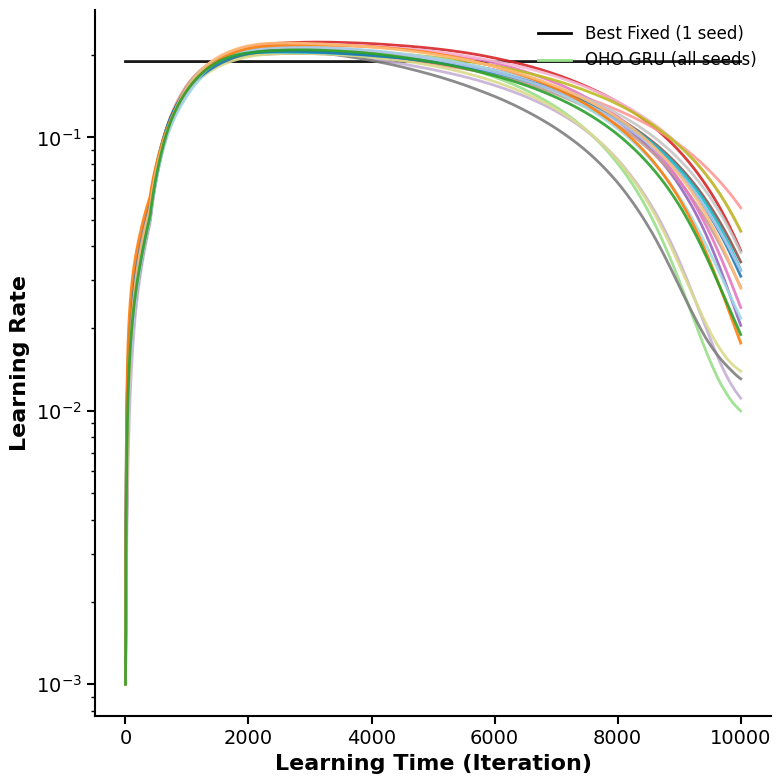

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# === THE FIX ===
# Type 42 fonts are TrueType fonts, which are embedded as text.
# The default is Type 3, which converts text to outlines/paths.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def plot_hyperparameters_for_best_config(experiments, smoothing_window=25, save_path='learning_rates.pdf'):
    """
    Plot learning rates over time with modifications:
    - ONLY ONE best fixed learning rate (black)
    - ALL seeds for other experiments (colored)
    - Log scale y-axis
    - Clean axes (left and bottom only)
    - Save as PDF with EDITABLE TEXT
    - Smoothed lines using a rolling average
    - **Figure size set to (8, 8) for consistency.**
    """
    # Set default font for better consistency (optional but good practice)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

    # Create figure - FIXED SIZE
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Get a colormap
    base_cmap = plt.get_cmap("tab20") 
    
    # Store legend information
    legend_elements = []

    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")

        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
        ]

        available_cols = [col for col in config_cols if col in df_metadata.columns]
        if len(available_cols) == 0:
            print("  Warning: No config columns found.")
            continue

        # --- 1. Identify Best Config ---
        config_summary = (
            df_metadata.groupby(available_cols)['metric/final_test_loss']
            .agg(['mean', 'count'])
            .compute()
        )
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]

        # --- 2. Filter Metadata ---
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        
        best_metadata = df_metadata[mask][[
            'task_id', 'config/seed/global_seed'
        ]].compute()

        best_task_ids = best_metadata['task_id'].values

        # --- 3. Get Time Series Data ---
        best_timeseries = df_timeseries[
            df_timeseries['task_id'].isin(best_task_ids.tolist())
        ][[
            'task_id', 'iteration',
            'metric/train_recurrent_learning_rate'
        ]].compute()

        # Distinct color offset per experiment
        exp_color_offset = (exp_idx * 5) % 20
        
        # Variable to track if we've added the main label
        main_label_added = False

        # --- 4. Plotting Loop ---
        for seed_idx, (_, row) in enumerate(best_metadata.iterrows()):
            task_id = row['task_id']

            # FIRST EXPERIMENT -> only first seed plotted (Fixed LR)
            if exp_idx == 0 and seed_idx > 0:
                continue

            task_data = best_timeseries[best_timeseries['task_id'] == task_id].sort_values('iteration')
            if len(task_data) < 2: # Need at least 2 points for a line/smoothing
                continue

            iterations = task_data['iteration'].values

            # Determine Color and Label
            if exp_idx == 0:
                color = "black"  # FIXED LR = BLACK
                label_text = "Best Fixed (1 seed)"
            else:
                color = base_cmap((exp_color_offset + seed_idx) % 20)
                label_text = name # The name of the experiment (e.g., 'Global OHO')

            # Process Learning Rate
            if 'metric/train_recurrent_learning_rate' in task_data.columns:
                lr_series = task_data['metric/train_recurrent_learning_rate']
                
                # === SMOOTHING LOGIC ===
                lrs_smoothed = lr_series.rolling(window=smoothing_window, min_periods=1).mean().values

                # Plot the smoothed line
                # Only give the label to the first line of the OHO experiment for the legend
                current_label = label_text if not main_label_added else None
                
                ax.plot(
                    iterations, lrs_smoothed, linewidth=2.0,
                    color=color, alpha=0.9,
                    label=current_label
                )
                
                if exp_idx > 0 and not main_label_added:
                    main_label_added = True
                    legend_elements.append({
                        'label': f"{name} (all seeds)", 
                        'color': color
                    })
                
                if exp_idx == 0 and not main_label_added:
                    main_label_added = True
                    legend_elements.append({
                        'label': label_text, 
                        'color': color
                    })


    # --- 5. Styling ---
    ax.set_yscale('log')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel("Learning Time (Iteration)", fontsize=16, fontweight='bold')
    ax.set_ylabel("Learning Rate", fontsize=16, fontweight='bold')
    
    ax.grid(False)
    
    ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
    ax.tick_params(axis='both', which='minor', width=1, length=3)
    
    # Add a formal legend using the collected colors/labels
    from matplotlib.lines import Line2D
    
    custom_lines = [Line2D([0], [0], color=info['color'], lw=2) for info in legend_elements]
    labels = [info['label'] for info in legend_elements]
    
    # Place legend outside or in a corner
    ax.legend(custom_lines, labels, loc='upper right', fontsize=12, frameon=False)
    
    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    # Save as editable PDF using the native savefig, which honors the Type 42 setting.
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    
    plt.show()

# Run it
plot_hyperparameters_for_best_config(gru_experiments, smoothing_window=400, save_path='gru_learning_rates.pdf')


Processing Fixed LR...
  Ranking configurations...
  BEST CONFIG: learning_rate=1.5e-01, learning_rate=1.0e-04, weight_decay=3.3e-03
  Mean Loss: 1.557237
  Found 20 runs for this best configuration.
    - Plotting Seed 1 (Task ID: baf22132e204426a92f19a26ca4b64c4)
    - Plotting Seed 2 (Task ID: 42ee333b5e9b4c319eafc426ef2afb33)
    - Plotting Seed 3 (Task ID: 2960eee2185544a88a273281ae27c6ab)
    - Plotting Seed 4 (Task ID: 9c4d4e8c580647c2bc759c6dcf8b7f9f)
    - Plotting Seed 5 (Task ID: 264a588f637740268dce014e8f0ff97a)

Processing OHO...
  Ranking configurations...
  BEST CONFIG: learning_rate=1.0e-03, learning_rate=1.0e-03, weight_decay=1.0e-05
  Mean Loss: 1.487182
  Found 20 runs for this best configuration.
    - Plotting Seed 1 (Task ID: a1a27300c9fe4acf82c7b0c6eb959d22)
    - Plotting Seed 2 (Task ID: c8125af8e2714df9bb90d38283c55be0)
    - Plotting Seed 3 (Task ID: 00cb461f464c4ac4bd5da4418bf1b5b5)
    - Plotting Seed 4 (Task ID: 7833a9c0d02447c1af0ba16ed305ea15)
    - Plo

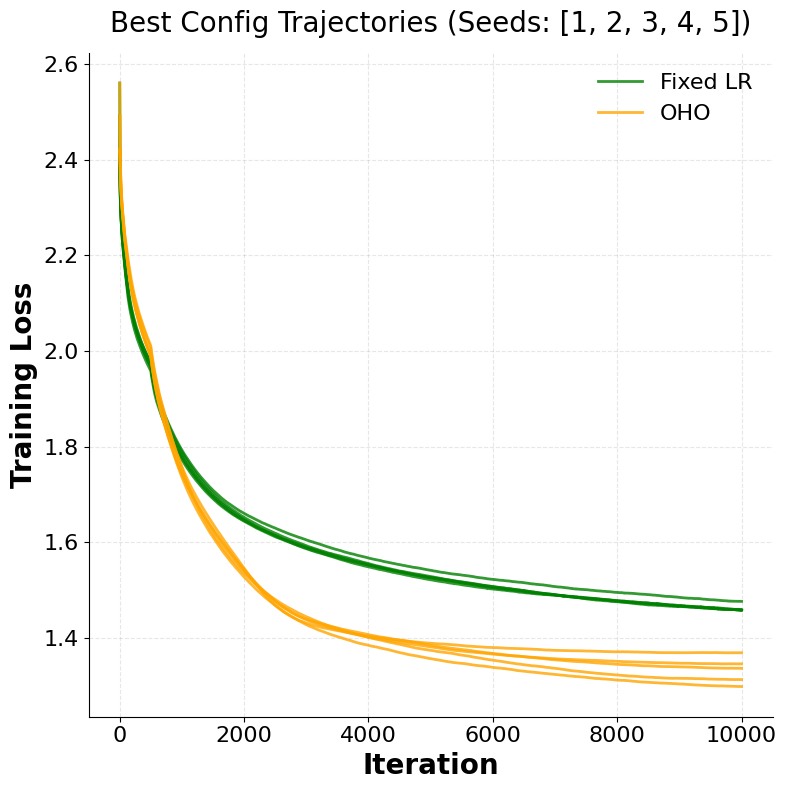

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd 
import os 

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def plot_best_config_selected_seeds(experiments, seeds, smoothing_window=10, save_path='best_config_multi_seed.pdf'):
    """
    1. Finds the BEST hyperparameter configuration for each experiment (based on mean final loss).
    2. Filters the data to ONLY include runs from that best configuration.
    3. Plots the specific seeds requested from that best configuration.
    """
    
    # Standardize figure size
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # White background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Experiments and Colors
    experiments_to_plot = experiments[:2]
    colors = ['green', 'orange'] 
    
    # Configuration columns to identify unique hyperparameters (from Code 1)
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value',
    ]

    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments_to_plot):
        print(f"\n{'='*40}")
        print(f"Processing {name}...")
        
        # --- STEP 1: Identify the Best Configuration ---
        
        # Check which config columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if not available_cols:
            print(f"  Warning: No config columns found. Using all data.")
            best_config_runs = df_metadata
        else:
            # Group by hyperparameters to find the best set
            print(f"  Ranking configurations...")
            config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
            config_summary = config_summary.reset_index().sort_values('mean')
            
            # The top row is the best configuration
            best_config = config_summary.iloc[0]
            
            # Print best config details
            config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.1e}" for col in available_cols])
            print(f"  BEST CONFIG: {config_str}")
            print(f"  Mean Loss: {best_config['mean']:.6f}")
            
            # Filter metadata to keep ONLY rows matching this best config
            mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
            for col in available_cols[1:]:
                mask &= (df_metadata[col] == best_config[col])
            
            # These are ALL the runs (seeds) for the best config
            best_config_runs = df_metadata[mask].compute()
            print(f"  Found {len(best_config_runs)} runs for this best configuration.")

        # --- STEP 2: Plot the Specific Seeds from the Best Config ---
        
        # Check seed column
        seed_col = 'config/seed/global_seed'
        if seed_col not in best_config_runs.columns:
            print("  Error: Seed column not found.")
            continue
            
        # Ensure seed column is int for matching
        try:
            best_config_runs[seed_col] = best_config_runs[seed_col].astype(int)
        except:
            pass
            
        legend_added = False # Flag to ensure we only add one label per experiment
        
        for seed_val in seeds:
            # Find the specific row for this seed WITHIN the best config runs
            seed_row = best_config_runs[best_config_runs[seed_col] == int(seed_val)]
            
            if len(seed_row) == 0:
                print(f"    - Seed {seed_val} not found in Best Config (might belong to a worse config or wasn't run).")
                continue
                
            task_id = seed_row.iloc[0]['task_id']
            print(f"    - Plotting Seed {seed_val} (Task ID: {task_id})")
            
            # Get time series
            task_data = df_timeseries[df_timeseries['task_id'] == task_id].compute().sort_values('iteration')
            
            # Check loss column
            loss_col = 'metric/train_loss'
            if loss_col not in task_data.columns:
                if 'metric/validation_loss' in task_data.columns:
                    loss_col = 'metric/validation_loss'
                else:
                    continue
            
            # Plot
            iterations = task_data['iteration'].values
            loss_values = task_data[loss_col]
            loss_smoothed = loss_values.rolling(window=smoothing_window, min_periods=1).mean().values
            
            # Label logic: Only label the first successful plot for this experiment
            label_txt = name if not legend_added else "_nolegend_"
            
            ax.plot(iterations, loss_smoothed, 
                    label=label_txt,
                    color=colors[exp_idx], 
                    linewidth=2,
                    alpha=0.8) # Slight transparency in case lines overlap
            
            legend_added = True

    # --- Styling ---
    ax.set_xlabel("Iteration", fontsize=20, fontweight='bold')
    ax.set_ylabel("Training Loss", fontsize=20, fontweight='bold')
    ax.set_title(f"Best Config Trajectories (Seeds: {seeds})", fontsize=20, pad=15)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    ax.legend(fontsize=16, frameon=False, loc='upper right')
    ax.grid(True, which='major', linestyle='--', alpha=0.3)
    
    # Adjust tick font sizes
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    
    # Save
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved to: {save_path}")
    plt.show()

# === EXAMPLE USAGE ===
# 1. It finds the best hyperparams for Fixed, and plots Seeds 1, 2, 3 using that config.
# 2. It finds the best hyperparams for OHO, and plots Seeds 1, 2, 3 using that config.
seeds_to_plot = [1, 2, 3, 4, 5]
plot_best_config_selected_seeds(experiments, seeds=seeds_to_plot, smoothing_window=500, save_path='best_config_multi_seed.pdf')


Processing Fixed LR GRU...
  Ranking configurations...
  BEST CONFIG: learning_rate=1.9e-01, learning_rate=1.0e-04, weight_decay=2.3e-03
  Mean Loss: 1.463746
  Found 20 runs for this best configuration.
    - Plotting Seed 1 (Task ID: f621a43ead5043e188a6292199c4ac1d)
    - Plotting Seed 2 (Task ID: b8332e007d6549a69887bd99deff65a2)
    - Plotting Seed 3 (Task ID: fca0eea85b204b85be3a5bc375d16b6d)
    - Plotting Seed 4 (Task ID: 88a153b77b4c4b3daaa4778928c7258c)
    - Plotting Seed 5 (Task ID: 710e24ee468f4630980cfcf6ae081fa1)

Processing OHO GRU...
  Ranking configurations...
  BEST CONFIG: learning_rate=1.0e-03, learning_rate=1.0e-04, weight_decay=1.0e-05
  Mean Loss: 1.397968
  Found 20 runs for this best configuration.
    - Plotting Seed 1 (Task ID: a7aa5fe0ad954d1c98a43c1116e9919f)
    - Plotting Seed 2 (Task ID: 5e8ba22ff2124d7995f6306c2ddc556c)
    - Plotting Seed 3 (Task ID: 4f26eed0772d452ebadb08e8a5f41d47)
    - Plotting Seed 4 (Task ID: 65d80c5ab56b40a49314d4a8505322d4)
 

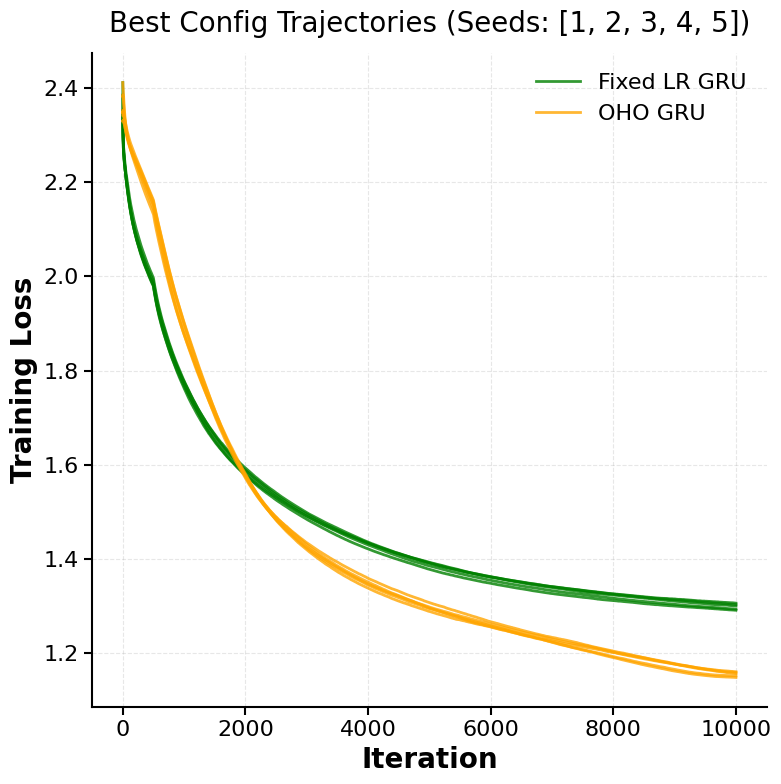

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd 
import os 

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def plot_best_config_selected_seeds(experiments, seeds, smoothing_window=10, save_path='best_config_multi_seed.pdf'):
    """
    1. Finds the BEST hyperparameter configuration for each experiment (based on mean final loss).
    2. Filters the data to ONLY include runs from that best configuration.
    3. Plots the specific seeds requested from that best configuration.
    """
    
    # Standardize figure size
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # White background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Experiments and Colors
    experiments_to_plot = experiments[:2]
    colors = ['green', 'orange'] 
    
    # Configuration columns to identify unique hyperparameters (from Code 1)
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value',
    ]

    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments_to_plot):
        print(f"\n{'='*40}")
        print(f"Processing {name}...")
        
        # --- STEP 1: Identify the Best Configuration ---
        
        # Check which config columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if not available_cols:
            print(f"  Warning: No config columns found. Using all data.")
            best_config_runs = df_metadata
        else:
            # Group by hyperparameters to find the best set
            print(f"  Ranking configurations...")
            config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
            config_summary = config_summary.reset_index().sort_values('mean')
            
            # The top row is the best configuration
            best_config = config_summary.iloc[0]
            
            # Print best config details
            config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.1e}" for col in available_cols])
            print(f"  BEST CONFIG: {config_str}")
            print(f"  Mean Loss: {best_config['mean']:.6f}")
            
            # Filter metadata to keep ONLY rows matching this best config
            mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
            for col in available_cols[1:]:
                mask &= (df_metadata[col] == best_config[col])
            
            # These are ALL the runs (seeds) for the best config
            best_config_runs = df_metadata[mask].compute()
            print(f"  Found {len(best_config_runs)} runs for this best configuration.")

        # --- STEP 2: Plot the Specific Seeds from the Best Config ---
        
        # Check seed column
        seed_col = 'config/seed/global_seed'
        if seed_col not in best_config_runs.columns:
            print("  Error: Seed column not found.")
            continue
            
        # Ensure seed column is int for matching
        try:
            best_config_runs[seed_col] = best_config_runs[seed_col].astype(int)
        except:
            pass
            
        legend_added = False # Flag to ensure we only add one label per experiment
        
        for seed_val in seeds:
            # Find the specific row for this seed WITHIN the best config runs
            seed_row = best_config_runs[best_config_runs[seed_col] == int(seed_val)]
            
            if len(seed_row) == 0:
                print(f"    - Seed {seed_val} not found in Best Config (might belong to a worse config or wasn't run).")
                continue
                
            task_id = seed_row.iloc[0]['task_id']
            print(f"    - Plotting Seed {seed_val} (Task ID: {task_id})")
            
            # Get time series
            task_data = df_timeseries[df_timeseries['task_id'] == task_id].compute().sort_values('iteration')
            
            # Check loss column
            loss_col = 'metric/train_loss'
            if loss_col not in task_data.columns:
                if 'metric/validation_loss' in task_data.columns:
                    loss_col = 'metric/validation_loss'
                else:
                    continue
            
            # Plot
            iterations = task_data['iteration'].values
            loss_values = task_data[loss_col]
            loss_smoothed = loss_values.rolling(window=smoothing_window, min_periods=1).mean().values
            
            # Label logic: Only label the first successful plot for this experiment
            label_txt = name if not legend_added else "_nolegend_"
            
            ax.plot(iterations, loss_smoothed, 
                    label=label_txt,
                    color=colors[exp_idx], 
                    linewidth=2,
                    alpha=0.8) # Slight transparency in case lines overlap
            
            legend_added = True

    # --- Styling ---
    ax.set_xlabel("Iteration", fontsize=20, fontweight='bold')
    ax.set_ylabel("Training Loss", fontsize=20, fontweight='bold')
    ax.set_title(f"Best Config Trajectories (Seeds: {seeds})", fontsize=20, pad=15)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    ax.legend(fontsize=16, frameon=False, loc='upper right')
    ax.grid(True, which='major', linestyle='--', alpha=0.3)
    
    # Adjust tick font sizes
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    
    # Save
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved to: {save_path}")
    plt.show()

# === EXAMPLE USAGE ===
# 1. It finds the best hyperparams for Fixed, and plots Seeds 1, 2, 3 using that config.
# 2. It finds the best hyperparams for OHO, and plots Seeds 1, 2, 3 using that config.
seeds_to_plot = [1, 2, 3, 4, 5]
plot_best_config_selected_seeds(gru_experiments, seeds=seeds_to_plot, smoothing_window=500, save_path='gru_best_config_multi_seed.pdf')

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import math
import os

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white' 

# Define the colors for all lines
TRAIN_LOSS_COLOR = 'blue'
TEST_LOSS_COLOR = 'purple'
LR_COLOR = 'green'


def plot_oho_seed_metrics_simple(
    experiment,
    target_seed,
    seed_col='config/seed/global_seed',
    ema_alpha=0.05, # Strong smoothing
    save_path='oho_seed_metrics_dynamics.pdf' # FIXED: Added save_path argument
):
    """
    Plot test loss, train loss, and recurrent learning rate for a specific seed.
    Figure size is set to (8, 8) for consistency.
    """
    exp_name, exp_meta, exp_ts = experiment
    
    print(f"\nProcessing {exp_name} for target seed {target_seed}...")

    exp_meta_df = exp_meta.compute()
    
    # 1. Prepare Metadata and Seed Filtering
    try:
        exp_meta_df[seed_col] = pd.to_numeric(exp_meta_df[seed_col], errors='coerce').astype(int)
    except Exception as e:
        print(f"  Warning: Could not convert seed column to int: {e}. Proceeding without conversion.")

    seed_rows = exp_meta_df[exp_meta_df[seed_col] == target_seed]
    
    if len(seed_rows) == 0:
        print(f"Error: Target seed {target_seed} not found in {exp_name} metadata. Skipping plot.")
        return
        
    exp_task_id = seed_rows.iloc[0]['task_id']
    print(f"Found task_id {exp_task_id} for Seed {target_seed}.")

    # 2. Get Time Series Data 
    ts_data = exp_ts[exp_ts['task_id'] == exp_task_id][
        ['iteration', 
         'metric/test_loss', 
         'metric/train_loss', 
         'metric/train_recurrent_learning_rate']
    ].compute().sort_values('iteration')
    
    if ts_data.empty:
        print(f"Error: Time series data for task {exp_task_id} is empty. Skipping plot.")
        return

    # 3. Apply Smoothing
    ts_data['smoothed_test_loss'] = ts_data['metric/test_loss'].ewm(alpha=ema_alpha).mean()
    ts_data['smoothed_train_loss'] = ts_data['metric/train_loss'].ewm(alpha=ema_alpha).mean()
    ts_data['smoothed_lr'] = ts_data['metric/train_recurrent_learning_rate'].ewm(alpha=ema_alpha).mean()

    # 4. Plotting
    
    # --- FIXED: Use consistent figure size (8, 8) ---
    fig, ax1 = plt.subplots(figsize=(8, 8))
    
    # === PLOTTING LINES ===
    
    # 1) Test Loss (Purple)
    ax1.plot(ts_data['iteration'], ts_data['smoothed_test_loss'], 
             color=TEST_LOSS_COLOR, linewidth=2.5)
             
    # 2) Train Loss (Blue)
    ax1.plot(ts_data['iteration'], ts_data['smoothed_train_loss'], 
             color=TRAIN_LOSS_COLOR, linestyle='--', linewidth=1.5)
             
    # --- Hyper-parameter Plotting (Right Axis, ax2) ---
    ax2 = ax1.twinx()
    
    # 3) Learning Rate (Green)
    ax2.plot(ts_data['iteration'], ts_data['smoothed_lr'], 
             color=LR_COLOR, linewidth=2.5, alpha=0.8)
             
    # === AXIS STYLING ===
    
    # Left Axis (Loss) - Increased font sizes
    ax1.set_xlabel("Learning Time (Iteration)", fontweight='bold', fontsize=16)
    ax1.set_ylabel("Loss", color='black', fontweight='bold', fontsize=16)
    ax1.grid(True, which='major', linestyle=':', alpha=0.5)
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    
    # Right Axis (Hyper-parameters) - Increased font sizes
    ax2.set_ylabel("Learning Rate", color=LR_COLOR, fontweight='bold', fontsize=16)
    ax2.tick_params(axis='y', labelcolor=LR_COLOR, labelsize=14)
    ax2.set_yscale('log')
    ax2.patch.set_facecolor('none')
    
    # Clean Spines
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False) 
    
    # === LEGEND FIX (Color-Coded Text Only) ===
    # Adjusted position for square plot and increased font size
    x_pos = 0.98
    y_start = 1.02
    dy = 0.03
    
    ax1.text(x_pos, y_start, "Train Loss", color=TRAIN_LOSS_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    ax1.text(x_pos, y_start - dy, "Test Loss", color=TEST_LOSS_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    ax1.text(x_pos, y_start - 2 * dy, "Learning Rate", color=LR_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    
    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    # Use the save_path argument.
    fig.savefig(save_path, format='pdf', bbox_inches='tight', transparent=False, dpi=300)
    print(f"\nPlot saved to: {save_path}")
    plt.close(fig) 

    print("\nProcessing complete.")

# ---
# CALL THE FUNCTION (NO COMMENTING)
# ---
# Note: The save_path argument is now optional but recommended for clarity
plot_oho_seed_metrics_simple(
    experiments[1],
    target_seed=1,
    save_path='oho_seed1_dynamics_8x8.pdf'
)


Processing OHO for target seed 1...
Found task_id a1a27300c9fe4acf82c7b0c6eb959d22 for Seed 1.

Plot saved to: oho_seed1_dynamics_8x8.pdf

Processing complete.


In [26]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import math
import os

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white' 

# Define the colors for all lines
TRAIN_LOSS_COLOR = 'blue'
TEST_LOSS_COLOR = 'purple'
LR_COLOR = 'green'


def plot_oho_seed_metrics_simple(
    experiment,
    target_seed,
    seed_col='config/seed/global_seed',
    ema_alpha=0.05, # Strong smoothing
    save_path='oho_seed_metrics_dynamics.pdf' # FIXED: Added save_path argument
):
    """
    Plot test loss, train loss, and recurrent learning rate for a specific seed.
    Figure size is set to (8, 8) for consistency.
    """
    exp_name, exp_meta, exp_ts = experiment
    
    print(f"\nProcessing {exp_name} for target seed {target_seed}...")

    exp_meta_df = exp_meta.compute()
    
    # 1. Prepare Metadata and Seed Filtering
    try:
        exp_meta_df[seed_col] = pd.to_numeric(exp_meta_df[seed_col], errors='coerce').astype(int)
    except Exception as e:
        print(f"  Warning: Could not convert seed column to int: {e}. Proceeding without conversion.")

    seed_rows = exp_meta_df[exp_meta_df[seed_col] == target_seed]
    
    if len(seed_rows) == 0:
        print(f"Error: Target seed {target_seed} not found in {exp_name} metadata. Skipping plot.")
        return
        
    exp_task_id = seed_rows.iloc[0]['task_id']
    print(f"Found task_id {exp_task_id} for Seed {target_seed}.")

    # 2. Get Time Series Data 
    ts_data = exp_ts[exp_ts['task_id'] == exp_task_id][
        ['iteration', 
         'metric/test_loss', 
         'metric/train_loss', 
         'metric/train_recurrent_learning_rate']
    ].compute().sort_values('iteration')
    
    if ts_data.empty:
        print(f"Error: Time series data for task {exp_task_id} is empty. Skipping plot.")
        return

    # 3. Apply Smoothing
    ts_data['smoothed_test_loss'] = ts_data['metric/test_loss'].ewm(alpha=ema_alpha).mean()
    ts_data['smoothed_train_loss'] = ts_data['metric/train_loss'].ewm(alpha=ema_alpha).mean()
    ts_data['smoothed_lr'] = ts_data['metric/train_recurrent_learning_rate'].ewm(alpha=ema_alpha).mean()

    # 4. Plotting
    
    # --- FIXED: Use consistent figure size (8, 8) ---
    fig, ax1 = plt.subplots(figsize=(8, 8))
    
    # === PLOTTING LINES ===
    
    # 1) Test Loss (Purple)
    ax1.plot(ts_data['iteration'], ts_data['smoothed_test_loss'], 
             color=TEST_LOSS_COLOR, linewidth=2.5)
             
    # 2) Train Loss (Blue)
    ax1.plot(ts_data['iteration'], ts_data['smoothed_train_loss'], 
             color=TRAIN_LOSS_COLOR, linestyle='--', linewidth=1.5)
             
    # --- Hyper-parameter Plotting (Right Axis, ax2) ---
    ax2 = ax1.twinx()
    
    # 3) Learning Rate (Green)
    ax2.plot(ts_data['iteration'], ts_data['smoothed_lr'], 
             color=LR_COLOR, linewidth=2.5, alpha=0.8)
             
    # === AXIS STYLING ===
    
    # Left Axis (Loss) - Increased font sizes
    ax1.set_xlabel("Learning Time (Iteration)", fontweight='bold', fontsize=16)
    ax1.set_ylabel("Loss", color='black', fontweight='bold', fontsize=16)
    ax1.grid(True, which='major', linestyle=':', alpha=0.5)
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    
    # Right Axis (Hyper-parameters) - Increased font sizes
    ax2.set_ylabel("Learning Rate", color=LR_COLOR, fontweight='bold', fontsize=16)
    ax2.tick_params(axis='y', labelcolor=LR_COLOR, labelsize=14)
    ax2.set_yscale('log')
    ax2.patch.set_facecolor('none')
    
    # Clean Spines
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False) 
    
    # === LEGEND FIX (Color-Coded Text Only) ===
    # Adjusted position for square plot and increased font size
    x_pos = 0.98
    y_start = 1.02
    dy = 0.03
    
    ax1.text(x_pos, y_start, "Train Loss", color=TRAIN_LOSS_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    ax1.text(x_pos, y_start - dy, "Test Loss", color=TEST_LOSS_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    ax1.text(x_pos, y_start - 2 * dy, "Learning Rate", color=LR_COLOR, 
             fontsize=12, ha='right', va='center', transform=ax1.transAxes, fontweight='bold')
    
    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    # Use the save_path argument.
    fig.savefig(save_path, format='pdf', bbox_inches='tight', transparent=False, dpi=300)
    print(f"\nPlot saved to: {save_path}")
    plt.close(fig) 

    print("\nProcessing complete.")

# ---
# CALL THE FUNCTION (NO COMMENTING)
# ---
# Note: The save_path argument is now optional but recommended for clarity
plot_oho_seed_metrics_simple(
    gru_experiments[1],
    target_seed=1,
    save_path='gru_oho_seed1_dynamics_8x8.pdf'
)


Processing OHO GRU for target seed 1...
Found task_id a7aa5fe0ad954d1c98a43c1116e9919f for Seed 1.

Plot saved to: gru_oho_seed1_dynamics_8x8.pdf

Processing complete.



Processing experiment 1: Fixed LR...

Processing experiment 2: OHO...
Best OHO mean loss = 1.487182

Plot saved as loss_landscape_8x8.pdf


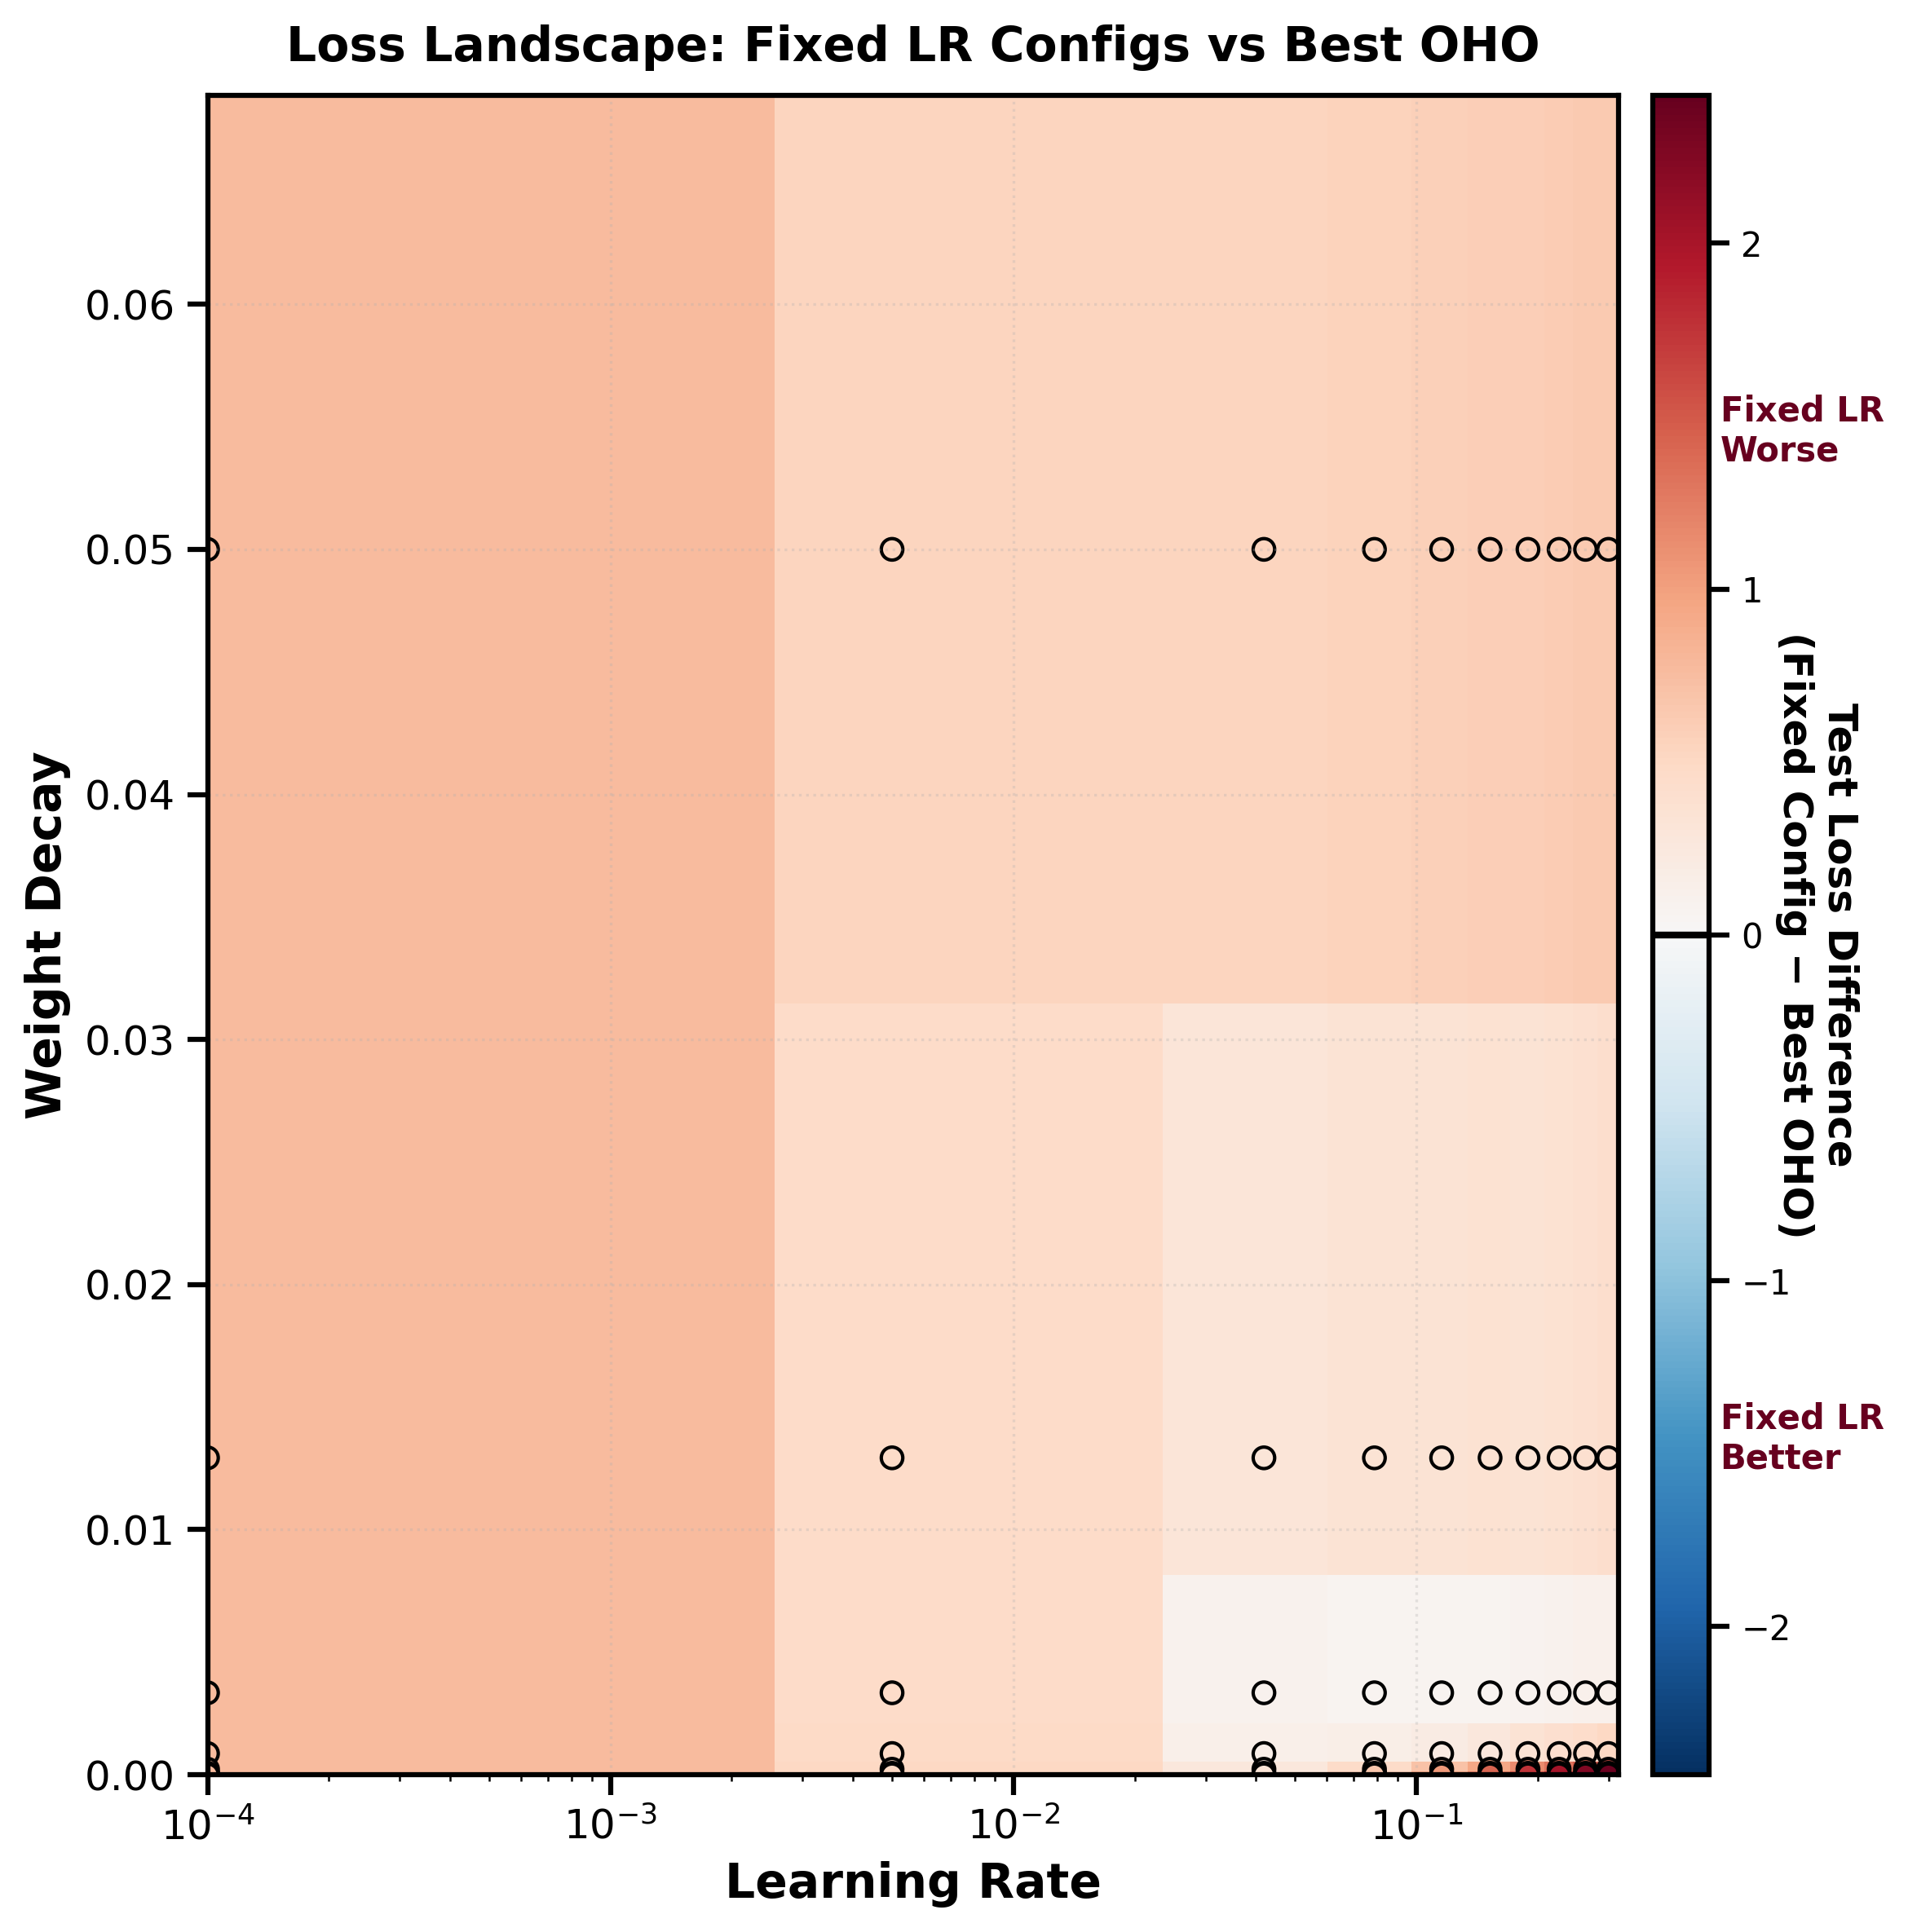

In [16]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd # Ensure pandas is available for type conversions
from matplotlib.patches import FancyArrowPatch

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
# Ensure settings are present even if not passed in the snippet
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white' 


def plot_3d_loss_landscape(exp1_tuple, exp2_tuple, save_path='loss_landscape.pdf'):
    """
    Plot loss-difference landscape only.
    NO TRAJECTORIES.
    Figure size is set to (8, 8) for consistency.
    
    Args:
        exp1_tuple: (name, df_metadata, df_timeseries) for Fixed LR.
        exp2_tuple: (name, df_metadata, df_timeseries) for OHO.
        save_path (str): Path to save the editable PDF output.
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1: {name1}...")
    
    # For exp1: group by LR and WD
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    if len(available_cols1) < 2:
        print("Missing LR/WD columns.")
        return
    
    config_summary1 = (
        df_metadata1.groupby(available_cols1)['metric/final_test_loss']
        .agg(['mean'])
        .compute()
        .reset_index()
    )
    
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"\nProcessing experiment 2: {name2}...")
    
    # Best config for exp2
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    config_summary2 = (
        df_metadata2.groupby(available_cols2)['metric/final_test_loss']
        .agg(['mean'])
        .compute()
        .reset_index()
        .sort_values('mean')
    )
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    print(f"Best {name2} mean loss = {best_loss2:.6f}")
    
    # Compute difference grid: (Fixed Loss) - (Best OHO Loss)
    loss_differences = losses - best_loss2
    
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                Diff_grid[j, i] = loss_differences[mask][0]
    
    # --- FIXED: Use consistent figure size (8, 8) ---
    fig, ax = plt.subplots(figsize=(8, 8))
    
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    
    im = ax.pcolormesh(
        LR_grid, WD_grid, Diff_grid,
        cmap='RdBu_r', shading='auto',
        vmin=-max_abs_diff, vmax=max_abs_diff
    )

    
    
    # zero contour
    ax.contour(
        LR_grid, WD_grid, Diff_grid,
        levels=[0], colors='black',
        linewidths=1.5, linestyles='--' # Scaled width
    )
    
    # scatter config points
    ax.scatter(
        lrs, wds, c=loss_differences,
        cmap='RdBu_r', s=40, edgecolors='black', # Scaled marker size
        vmin=-max_abs_diff, vmax=max_abs_diff
    )
    
    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    
    # Adjusted label to reflect (Fixed - Best OHO) difference
    cbar.set_label('Test Loss Difference\n(Fixed Config − Best OHO)',
                fontsize=12, rotation=270, labelpad=20, fontweight='bold') # Scaled font size

    # Add a clear zero separator
    cbar.ax.axhline(y=0, color='black', linewidth=2)

    # Pick colors DIRECTLY from the colormap
    cmap_obj = plt.get_cmap('RdBu_r')
    
    # The difference is (Fixed - Best OHO)
    # Positive (Red) means Fixed is worse than Best OHO -> Best OHO is better.
    # Negative (Blue) means Fixed is better than Best OHO -> Best OHO is worse.
    worse_color  = cmap_obj( (max_abs_diff - (-max_abs_diff)) / (2 * max_abs_diff) ) # Blue (Fixed is Better)
    better_color = cmap_obj( (max_abs_diff + max_abs_diff) / (2 * max_abs_diff) )   # Red (Fixed is Worse/OHO is Better)

    # Label positions (scaled font size)
    cbar.ax.text(
        1.2, -max_abs_diff * 0.6, f"{name1}\nBetter",
        ha='left', va='center', fontsize=10,
        color=worse_color, fontweight='bold', transform=cbar.ax.transData
    )

    cbar.ax.text(
        1.2, max_abs_diff * 0.6, f"{name1}\nWorse",
        ha='left', va='center', fontsize=10,
        color=better_color, fontweight='bold', transform=cbar.ax.transData
    )
    
    # Labels (scaled font size)
    ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay', fontsize=14, fontweight='bold')
    ax.set_title(f'Loss Landscape: {name1} Configs vs Best {name2}', fontsize=14, fontweight='bold', pad=10)
    
    # log scaling if meaningful
    if lrs.min() > 0 and lrs.max()/lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max()/wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, linestyle=':', alpha=0.3)
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    
    plt.show()

# Example usage:
plot_3d_loss_landscape(experiments[0], experiments[1], save_path='loss_landscape_8x8.pdf')


Processing Fixed LR vs OHO...
Scanning OHO for dynamic columns...
Selected LR: metric/train_recurrent_learning_rate (Std: 6.10e-02)
Selected WD: metric/train_recurrent_weight_decay (Std: 6.25e-03)

Plot saved as loss_landscape_hybrid.pdf


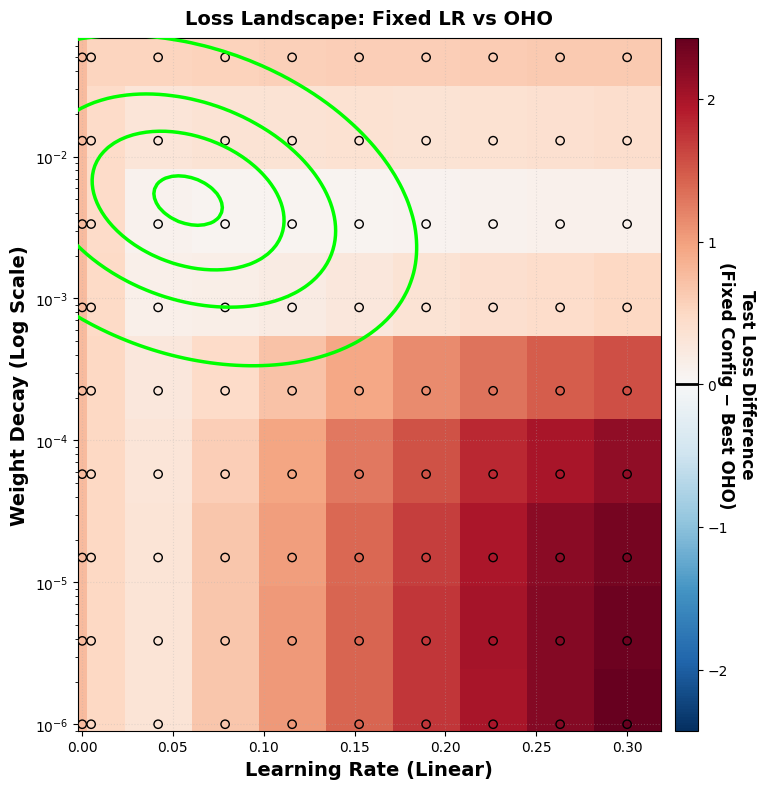

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# === GLOBAL FONTS ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def get_highest_variance_column(df, keyword):
    """
    Scans dataframe for 'keyword'. Returns the column name with the highest variance.
    """
    candidates = [c for c in df.columns if keyword in c]
    best_col = None
    max_std = -1.0
    best_vals = None
    
    for col in candidates:
        try:
            # Check if dask or pandas
            raw = df[col].compute() if hasattr(df[col], 'compute') else df[col]
            vals = pd.to_numeric(raw, errors='coerce').dropna().values
            
            if len(vals) < 2: continue
            
            std = vals.std()
            if std > max_std:
                max_std = std
                best_col = col
                best_vals = vals
        except:
            continue
            
    return best_col, best_vals, max_std

def plot_landscape_hybrid_scale(exp1_tuple, exp2_tuple, save_path='loss_landscape_hybrid.pdf'):
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing {name1} vs {name2}...")
    
    # --- 1. EXP 1 HEATMAP DATA ---
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail1 = [c for c in config_cols1 if c in df_metadata1.columns]
    
    summary1 = df_metadata1.groupby(avail1)['metric/final_test_loss'].agg(['mean']).compute().reset_index()
    
    lrs_grid = pd.to_numeric(summary1[avail1[0]], errors='coerce').values
    wds_grid = pd.to_numeric(summary1[avail1[1]], errors='coerce').values
    losses_grid = summary1['mean'].values

    # --- 2. EXP 2 BEST LOSS (Scalar Baseline) ---
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    summary2 = df_metadata2.groupby(avail2)['metric/final_test_loss'].agg(['mean']).compute().reset_index().sort_values('mean')
    best_loss2 = float(summary2.iloc[0]['mean'])

    # --- 3. AUTO-DETECT DYNAMIC COLUMNS ---
    print(f"Scanning {name2} for dynamic columns...")
    
    col_lr, vals_lr, std_lr = get_highest_variance_column(df_timeseries2, 'learning_rate')
    col_wd, vals_wd, std_wd = get_highest_variance_column(df_timeseries2, 'weight_decay')
    
    # Fallback to metadata
    if col_lr is None or std_lr == 0:
        col_lr, vals_lr, std_lr = get_highest_variance_column(df_metadata2, 'learning_rate')
    if col_wd is None or std_wd == 0:
        col_wd, vals_wd, std_wd = get_highest_variance_column(df_metadata2, 'weight_decay')
        
    print(f"Selected LR: {col_lr} (Std: {std_lr:.2e})")
    print(f"Selected WD: {col_wd} (Std: {std_wd:.2e})")
    
    # Filter valid positive values (WD needs to be positive for Log, LR can be 0 but usually positive)
    mask = (vals_wd > 1e-12) & np.isfinite(vals_lr) & np.isfinite(vals_wd)
    lrs_dist = vals_lr[mask]
    wds_dist = vals_wd[mask]

    # --- 4. PLOTTING ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # A. Heatmap (Landscape)
    loss_diff = losses_grid - best_loss2
    max_diff = np.nanmax(np.abs(loss_diff))
    
    u_lr = np.sort(np.unique(lrs_grid))
    u_wd = np.sort(np.unique(wds_grid))
    LR_mesh, WD_mesh = np.meshgrid(u_lr, u_wd)
    Z_mesh = np.full(LR_mesh.shape, np.nan)
    
    for i, lr in enumerate(u_lr):
        for j, wd in enumerate(u_wd):
            m = np.isclose(lrs_grid, lr) & np.isclose(wds_grid, wd)
            if np.any(m):
                Z_mesh[j, i] = loss_diff[m][0]

    im = ax.pcolormesh(
        LR_mesh, WD_mesh, Z_mesh,
        cmap='RdBu_r', shading='auto',
        vmin=-max_diff, vmax=max_diff, zorder=1
    )
    
    # --- HELPER TO CALCULATE HEATMAP BOUNDARIES ---
    # Calculates the edges of the cells so we can lock the axes to them
    def get_bounds(u_vals):
        if len(u_vals) < 2:
            return u_vals[0]*0.9, u_vals[0]*1.1
        # Midpoints between grid centers
        mids = (u_vals[:-1] + u_vals[1:]) / 2.0
        # Extrapolate outer edges
        start = u_vals[0] - (mids[0] - u_vals[0])
        end = u_vals[-1] + (u_vals[-1] - mids[-1])
        return start, end

    x_min, x_max = get_bounds(u_lr)
    y_min, y_max = get_bounds(u_wd)
    # -----------------------------------------------
    
    # Zero contour for landscape
    ax.contour(LR_mesh, WD_mesh, Z_mesh, levels=[0], colors='black', linestyles='--', zorder=2)
    
    # Scatter Grid Points (Exp 1)
    ax.scatter(lrs_grid, wds_grid, c=loss_diff, cmap='RdBu_r', 
               edgecolors='black', vmin=-max_diff, vmax=max_diff, zorder=3)

    # B. GAUSSIAN CONTOURS (Hybrid Fit: Linear LR, Log WD)
    if std_lr > 1e-12 and std_wd > 1e-12 and len(lrs_dist) > 1:
        
        # --- THE HYBRID TRANSFORMATION ---
        # LR remains LINEAR
        # WD becomes LOG
        fit_lr = lrs_dist 
        fit_wd_log = np.log10(wds_dist)
        
        data_fit = np.vstack([fit_lr, fit_wd_log]).T
        
        mu_fit = np.mean(data_fit, axis=0)
        cov_fit = np.cov(data_fit, rowvar=False) + np.eye(2) * 1e-8
        
        try:
            rv = multivariate_normal(mu_fit, cov_fit)
            
            # Create grid in FIT SPACE (Linear X, Log Y)
            min_x, max_x = mu_fit[0]-3*np.sqrt(cov_fit[0,0]), mu_fit[0]+3*np.sqrt(cov_fit[0,0])
            min_y, max_y = mu_fit[1]-3*np.sqrt(cov_fit[1,1]), mu_fit[1]+3*np.sqrt(cov_fit[1,1])
            
            xx_fit, yy_fit_log = np.mgrid[min_x:max_x:100j, min_y:max_y:100j]
            pos_fit = np.dstack((xx_fit, yy_fit_log))
            z_pdf = rv.pdf(pos_fit)
            
            # Transform Y back to LINEAR for plotting (X stays same)
            xx_plot = xx_fit
            yy_plot = 10**yy_fit_log
            
            if z_pdf.max() > z_pdf.min():
                # --- STRICTLY 4 LEVELS ---
                levels = np.linspace(
                    z_pdf.min() + (z_pdf.max() - z_pdf.min()) * 0.1, 
                    z_pdf.max() * 0.95, 
                    4
                )
                
                # Plot contours - they will be clipped by axes limits set later
                ax.contour(
                    xx_plot, yy_plot, z_pdf,
                    levels=levels,
                    colors='lime',
                    linewidths=2.5,
                    zorder=10
                )
        except Exception as e:
            print(f"Gaussian fit failed: {e}")

    # C. Styling - HYBRID SCALES & STRICT LIMITS
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # --- STRICTLY APPLY HEATMAP BOUNDARIES ---
    ax.set_xlim(x_min, x_max)
    
    # For Y (log scale), ensure we don't hit 0 or negative
    if y_min <= 0:
        # If the heatmap bottom is 0, we can't show it in log scale.
        # Find the lowest positive value in the data to define the bottom.
        pos_vals = u_wd[u_wd > 0]
        if len(pos_vals) > 0:
            y_min = pos_vals.min() * 0.9 # Small margin below lowest positive
        else:
            y_min = 1e-4 # Fallback
            
    ax.set_ylim(y_min, y_max)
    # -----------------------------------------

    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('Test Loss Difference\n(Fixed Config − Best OHO)',
                   fontsize=12, rotation=270, labelpad=20, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2)
    
    ax.set_xlabel('Learning Rate (Linear)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay (Log Scale)', fontsize=14, fontweight='bold')
    ax.set_title(f'Loss Landscape: {name1} vs {name2}', fontsize=14, fontweight='bold', pad=10)
    
    # Grid: X is linear, Y is log
    ax.grid(True, linestyle=':', alpha=0.3, which='major')
    
    plt.tight_layout()
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    plt.show()

# Example Usage:
plot_landscape_hybrid_scale(experiments[0], experiments[1])


Processing Fixed LR Vanilla vs OHO Vanilla...
Scanning OHO Vanilla for dynamic columns...


Selected LR: metric/train_recurrent_learning_rate (Std: 6.10e-02)
Selected WD: metric/train_recurrent_weight_decay (Std: 6.25e-03)

Plot saved as loss_landscape_hybrid.pdf


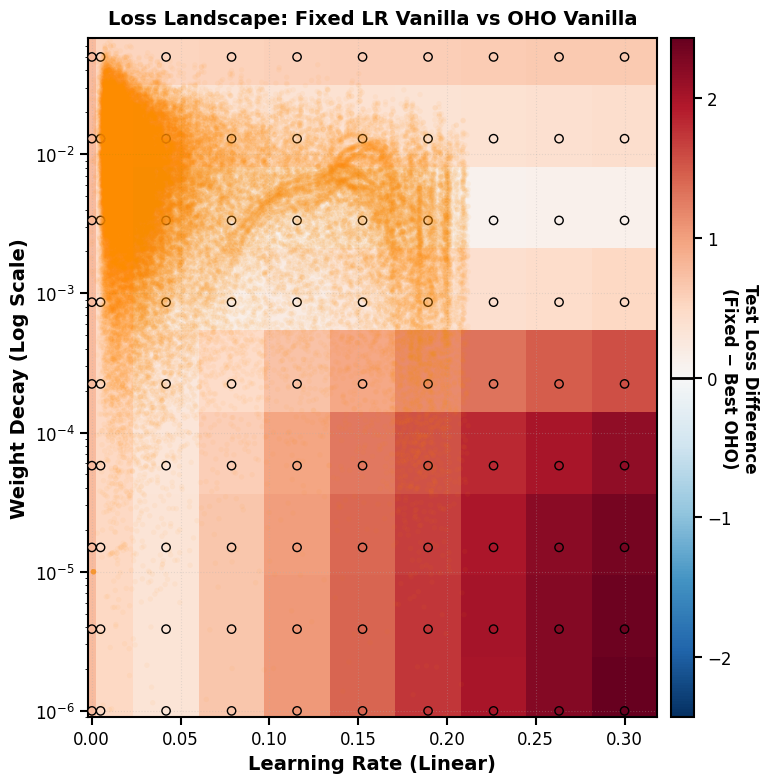

In [31]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# === GLOBAL FONTS ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def get_highest_variance_column(df, keyword):
    """
    Scans dataframe for 'keyword'. Returns the column name with the highest variance.
    """
    candidates = [c for c in df.columns if keyword in c]
    best_col = None
    max_std = -1.0
    best_vals = None
    
    for col in candidates:
        try:
            # Check if dask or pandas
            raw = df[col].compute() if hasattr(df[col], 'compute') else df[col]
            vals = pd.to_numeric(raw, errors='coerce').dropna().values
            
            if len(vals) < 2: continue
            
            std = vals.std()
            if std > max_std:
                max_std = std
                best_col = col
                best_vals = vals
        except:
            continue
            
    return best_col, best_vals, max_std

def plot_landscape_hybrid_scale(exp1_tuple, exp2_tuple, save_path='loss_landscape_hybrid.pdf'):
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing {name1} vs {name2}...")
    
    # --- 1. EXP 1 HEATMAP DATA ---
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail1 = [c for c in config_cols1 if c in df_metadata1.columns]
    
    summary1 = df_metadata1.groupby(avail1)['metric/final_test_loss'].agg(['mean']).compute().reset_index()
    
    lrs_grid = pd.to_numeric(summary1[avail1[0]], errors='coerce').values
    wds_grid = pd.to_numeric(summary1[avail1[1]], errors='coerce').values
    losses_grid = summary1['mean'].values

    # --- 2. EXP 2 BEST LOSS (Scalar Baseline) ---
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    summary2 = df_metadata2.groupby(avail2)['metric/final_test_loss'].agg(['mean']).compute().reset_index().sort_values('mean')
    best_loss2 = float(summary2.iloc[0]['mean'])

    # --- 3. AUTO-DETECT DYNAMIC COLUMNS ---
    print(f"Scanning {name2} for dynamic columns...")
    
    col_lr, vals_lr, std_lr = get_highest_variance_column(df_timeseries2, 'learning_rate')
    col_wd, vals_wd, std_wd = get_highest_variance_column(df_timeseries2, 'weight_decay')
    
    # Fallback to metadata
    if col_lr is None or std_lr == 0:
        col_lr, vals_lr, std_lr = get_highest_variance_column(df_metadata2, 'learning_rate')
    if col_wd is None or std_wd == 0:
        col_wd, vals_wd, std_wd = get_highest_variance_column(df_metadata2, 'weight_decay')
        
    print(f"Selected LR: {col_lr} (Std: {std_lr:.2e})")
    print(f"Selected WD: {col_wd} (Std: {std_wd:.2e})")
    
    # Filter valid positive values (WD needs to be positive for Log, LR can be 0 but usually positive)
    mask = (vals_wd > 1e-12) & np.isfinite(vals_lr) & np.isfinite(vals_wd)
    lrs_dist = vals_lr[mask]
    wds_dist = vals_wd[mask]

    # --- 4. PLOTTING ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # A. Heatmap (Landscape)
    loss_diff = losses_grid - best_loss2
    max_diff = np.nanmax(np.abs(loss_diff))
    
    u_lr = np.sort(np.unique(lrs_grid))
    u_wd = np.sort(np.unique(wds_grid))
    LR_mesh, WD_mesh = np.meshgrid(u_lr, u_wd)
    Z_mesh = np.full(LR_mesh.shape, np.nan)
    
    for i, lr in enumerate(u_lr):
        for j, wd in enumerate(u_wd):
            m = np.isclose(lrs_grid, lr) & np.isclose(wds_grid, wd)
            if np.any(m):
                Z_mesh[j, i] = loss_diff[m][0]

    im = ax.pcolormesh(
        LR_mesh, WD_mesh, Z_mesh,
        cmap='RdBu_r', shading='auto',
        vmin=-max_diff, vmax=max_diff, zorder=1
    )
    
    # --- HELPER TO CALCULATE HEATMAP BOUNDARIES ---
    def get_bounds(u_vals):
        if len(u_vals) < 2:
            return u_vals[0]*0.9, u_vals[0]*1.1
        mids = (u_vals[:-1] + u_vals[1:]) / 2.0
        start = u_vals[0] - (mids[0] - u_vals[0])
        end = u_vals[-1] + (u_vals[-1] - mids[-1])
        return start, end

    x_min, x_max = get_bounds(u_lr)
    y_min, y_max = get_bounds(u_wd)
    # -----------------------------------------------
    
    # Zero contour for landscape
    ax.contour(LR_mesh, WD_mesh, Z_mesh, levels=[0], colors='black', linestyles='--', zorder=2)
    
    # Scatter Grid Points (Exp 1 - The "Fixed" points)
    ax.scatter(lrs_grid, wds_grid, c=loss_diff, cmap='RdBu_r', 
               edgecolors='black', vmin=-max_diff, vmax=max_diff, zorder=3)

    # B. POINT CLOUD ONLY (No Gaussian contours)
    if std_lr > 1e-12 and std_wd > 1e-12 and len(lrs_dist) > 1:
        # Plot the raw distribution data (linear scale)
        ax.scatter(
            lrs_dist, wds_dist, 
            s=15,               # Small dot size
            c='darkorange',     # Contrast color
            alpha=0.05,         # SIGNIFICANTLY REDUCED ALPHA FOR TRANSPARENCY
            edgecolors='none',  # No borders for cleaner "cloud" look
            zorder=11,          # On top of everything
            clip_path=ax.patch, # Ensure points outside bounds are clipped
            label='OHO Samples' # Label for potential legend
        )

    # C. Styling - HYBRID SCALES & STRICT LIMITS
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # --- STRICTLY APPLY HEATMAP BOUNDARIES ---
    ax.set_xlim(x_min, x_max)
    
    if y_min <= 0:
        pos_vals = u_wd[u_wd > 0]
        if len(pos_vals) > 0:
            y_min = pos_vals.min() * 0.9 
        else:
            y_min = 1e-4 
            
    ax.set_ylim(y_min, y_max)
    # -----------------------------------------

    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    # UPDATED LABEL AS REQUESTED
    cbar.set_label('Test Loss Difference\n(Fixed − Best OHO)',
                   fontsize=12, rotation=270, labelpad=20, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2)
    
    ax.set_xlabel('Learning Rate (Linear)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay (Log Scale)', fontsize=14, fontweight='bold')
    ax.set_title(f'Loss Landscape: {name1} vs {name2}', fontsize=14, fontweight='bold', pad=10)
    
    ax.grid(True, linestyle=':', alpha=0.3, which='major')
    
    plt.tight_layout()
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    plt.show()

# Example Usage:
plot_landscape_hybrid_scale(experiments[0], experiments[1], save_path='loss_landscape_hybrid.pdf')


Processing Fixed LR GRU vs OHO GRU...
Scanning OHO GRU for dynamic columns...


Selected LR: metric/train_recurrent_learning_rate (Std: 6.06e-02)
Selected WD: metric/train_recurrent_weight_decay (Std: 2.53e-03)

Plot saved as gru_loss_landscape_hybrid.pdf


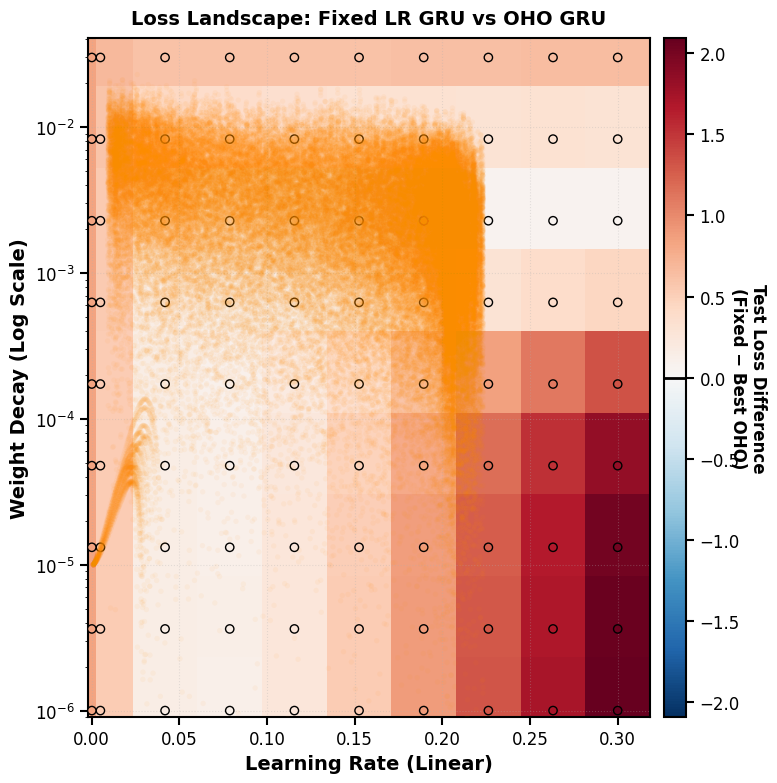

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# === GLOBAL FONTS ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def get_highest_variance_column(df, keyword):
    """
    Scans dataframe for 'keyword'. Returns the column name with the highest variance.
    """
    candidates = [c for c in df.columns if keyword in c]
    best_col = None
    max_std = -1.0
    best_vals = None
    
    for col in candidates:
        try:
            # Check if dask or pandas
            raw = df[col].compute() if hasattr(df[col], 'compute') else df[col]
            vals = pd.to_numeric(raw, errors='coerce').dropna().values
            
            if len(vals) < 2: continue
            
            std = vals.std()
            if std > max_std:
                max_std = std
                best_col = col
                best_vals = vals
        except:
            continue
            
    return best_col, best_vals, max_std

def plot_landscape_hybrid_scale(exp1_tuple, exp2_tuple, save_path='loss_landscape_hybrid.pdf'):
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing {name1} vs {name2}...")
    
    # --- 1. EXP 1 HEATMAP DATA ---
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail1 = [c for c in config_cols1 if c in df_metadata1.columns]
    
    summary1 = df_metadata1.groupby(avail1)['metric/final_test_loss'].agg(['mean']).compute().reset_index()
    
    lrs_grid = pd.to_numeric(summary1[avail1[0]], errors='coerce').values
    wds_grid = pd.to_numeric(summary1[avail1[1]], errors='coerce').values
    losses_grid = summary1['mean'].values

    # --- 2. EXP 2 BEST LOSS (Scalar Baseline) ---
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    summary2 = df_metadata2.groupby(avail2)['metric/final_test_loss'].agg(['mean']).compute().reset_index().sort_values('mean')
    best_loss2 = float(summary2.iloc[0]['mean'])

    # --- 3. AUTO-DETECT DYNAMIC COLUMNS ---
    print(f"Scanning {name2} for dynamic columns...")
    
    col_lr, vals_lr, std_lr = get_highest_variance_column(df_timeseries2, 'learning_rate')
    col_wd, vals_wd, std_wd = get_highest_variance_column(df_timeseries2, 'weight_decay')
    
    # Fallback to metadata
    if col_lr is None or std_lr == 0:
        col_lr, vals_lr, std_lr = get_highest_variance_column(df_metadata2, 'learning_rate')
    if col_wd is None or std_wd == 0:
        col_wd, vals_wd, std_wd = get_highest_variance_column(df_metadata2, 'weight_decay')
        
    print(f"Selected LR: {col_lr} (Std: {std_lr:.2e})")
    print(f"Selected WD: {col_wd} (Std: {std_wd:.2e})")
    
    # Filter valid positive values (WD needs to be positive for Log, LR can be 0 but usually positive)
    mask = (vals_wd > 1e-12) & np.isfinite(vals_lr) & np.isfinite(vals_wd)
    lrs_dist = vals_lr[mask]
    wds_dist = vals_wd[mask]

    # --- 4. PLOTTING ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # A. Heatmap (Landscape)
    loss_diff = losses_grid - best_loss2
    max_diff = np.nanmax(np.abs(loss_diff))
    
    u_lr = np.sort(np.unique(lrs_grid))
    u_wd = np.sort(np.unique(wds_grid))
    LR_mesh, WD_mesh = np.meshgrid(u_lr, u_wd)
    Z_mesh = np.full(LR_mesh.shape, np.nan)
    
    for i, lr in enumerate(u_lr):
        for j, wd in enumerate(u_wd):
            m = np.isclose(lrs_grid, lr) & np.isclose(wds_grid, wd)
            if np.any(m):
                Z_mesh[j, i] = loss_diff[m][0]

    im = ax.pcolormesh(
        LR_mesh, WD_mesh, Z_mesh,
        cmap='RdBu_r', shading='auto',
        vmin=-max_diff, vmax=max_diff, zorder=1
    )
    
    # --- HELPER TO CALCULATE HEATMAP BOUNDARIES ---
    def get_bounds(u_vals):
        if len(u_vals) < 2:
            return u_vals[0]*0.9, u_vals[0]*1.1
        mids = (u_vals[:-1] + u_vals[1:]) / 2.0
        start = u_vals[0] - (mids[0] - u_vals[0])
        end = u_vals[-1] + (u_vals[-1] - mids[-1])
        return start, end

    x_min, x_max = get_bounds(u_lr)
    y_min, y_max = get_bounds(u_wd)
    # -----------------------------------------------
    
    # Zero contour for landscape
    ax.contour(LR_mesh, WD_mesh, Z_mesh, levels=[0], colors='black', linestyles='--', zorder=2)
    
    # Scatter Grid Points (Exp 1 - The "Fixed" points)
    ax.scatter(lrs_grid, wds_grid, c=loss_diff, cmap='RdBu_r', 
               edgecolors='black', vmin=-max_diff, vmax=max_diff, zorder=3)

    # B. POINT CLOUD ONLY (No Gaussian contours)
    if std_lr > 1e-12 and std_wd > 1e-12 and len(lrs_dist) > 1:
        # Plot the raw distribution data (linear scale)
        ax.scatter(
            lrs_dist, wds_dist, 
            s=15,               # Small dot size
            c='darkorange',     # Contrast color
            alpha=0.05,         # SIGNIFICANTLY REDUCED ALPHA FOR TRANSPARENCY
            edgecolors='none',  # No borders for cleaner "cloud" look
            zorder=11,          # On top of everything
            clip_path=ax.patch, # Ensure points outside bounds are clipped
            label='OHO Samples' # Label for potential legend
        )

    # C. Styling - HYBRID SCALES & STRICT LIMITS
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # --- STRICTLY APPLY HEATMAP BOUNDARIES ---
    ax.set_xlim(x_min, x_max)
    
    if y_min <= 0:
        pos_vals = u_wd[u_wd > 0]
        if len(pos_vals) > 0:
            y_min = pos_vals.min() * 0.9 
        else:
            y_min = 1e-4 
            
    ax.set_ylim(y_min, y_max)
    # -----------------------------------------

    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    # UPDATED LABEL AS REQUESTED
    cbar.set_label('Test Loss Difference\n(Fixed − Best OHO)',
                   fontsize=12, rotation=270, labelpad=20, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2)
    
    ax.set_xlabel('Learning Rate (Linear)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay (Log Scale)', fontsize=14, fontweight='bold')
    ax.set_title(f'Loss Landscape: {name1} vs {name2}', fontsize=14, fontweight='bold', pad=10)
    
    ax.grid(True, linestyle=':', alpha=0.3, which='major')
    
    plt.tight_layout()
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    plt.show()

# Example Usage:
plot_landscape_hybrid_scale(gru_experiments[0], gru_experiments[1], save_path='gru_loss_landscape_hybrid.pdf')

<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:107: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:107: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_442/357174324.py:70: SyntaxWarning: invalid escape sequence '\l'
  print(f"Filtered to {len(losses_grid)} grid points (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")
/tmp/ipykernel_442/357174324.py:107: SyntaxWarning: invalid escape sequence '\l'
  print(f"Filtered OHO samples to {len(lrs_dist)} (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")



Processing Fixed LR vs OHO...
Filtered to 35 grid points (LR $\le$ 0.2 AND WD $> 0.0001$)
Scanning OHO for dynamic columns...
Selected LR: metric/train_recurrent_learning_rate (Std: 6.10e-02)
Selected WD: metric/train_recurrent_weight_decay (Std: 6.25e-03)
Filtered OHO samples to 77481 (LR $\le$ 0.2 AND WD $> 0.0001$)


/tmp/ipykernel_442/357174324.py:70: SyntaxWarning: invalid escape sequence '\l'
  print(f"Filtered to {len(losses_grid)} grid points (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")
/tmp/ipykernel_442/357174324.py:107: SyntaxWarning: invalid escape sequence '\l'
  print(f"Filtered OHO samples to {len(lrs_dist)} (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")


NameError: name 'title_text' is not defined

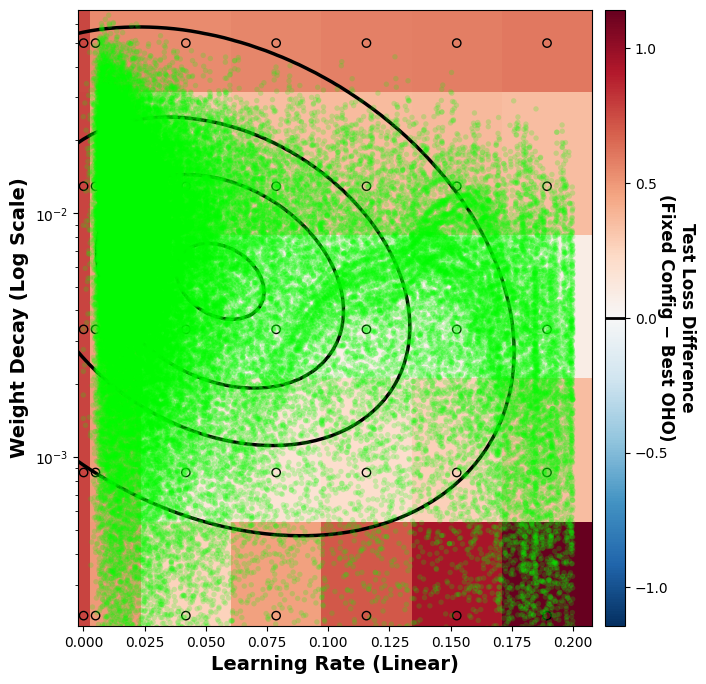

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

# === GLOBAL FONTS ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

def get_highest_variance_column(df, keyword):
    """
    Scans dataframe for 'keyword'. Returns the column name with the highest variance.
    """
    candidates = [c for c in df.columns if keyword in c]
    best_col = None
    max_std = -1.0
    best_vals = None
    
    for col in candidates:
        try:
            # Check if dask or pandas
            raw = df[col].compute() if hasattr(df[col], 'compute') else df[col]
            vals = pd.to_numeric(raw, errors='coerce').dropna().values
            
            if len(vals) < 2: continue
            
            std = vals.std()
            if std > max_std:
                max_std = std
                best_col = col
                best_vals = vals
        except:
            continue
            
    return best_col, best_vals, max_std

def plot_landscape_hybrid_scale(exp1_tuple, exp2_tuple, save_path='loss_landscape_hybrid_zoomed.pdf'):
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing {name1} vs {name2}...")
    
    # --- Define Cutoffs ---
    LR_CUTOFF = 0.2
    WD_CUTOFF = 1e-4
    
    # --- 1. EXP 1 HEATMAP DATA (Fixed Config) ---
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail1 = [c for c in config_cols1 if c in df_metadata1.columns]
    
    summary1 = df_metadata1.groupby(avail1)['metric/final_test_loss'].agg(['mean']).compute().reset_index()
    
    lrs_grid = pd.to_numeric(summary1[avail1[0]], errors='coerce').values
    wds_grid = pd.to_numeric(summary1[avail1[1]], errors='coerce').values
    losses_grid = summary1['mean'].values

    # === FILTER 1: Apply BOTH LR and WD cutoffs to Fixed Grid Data ===
    keep_mask = (lrs_grid <= LR_CUTOFF) & (wds_grid > WD_CUTOFF)
    
    lrs_grid = lrs_grid[keep_mask]
    wds_grid = wds_grid[keep_mask]
    losses_grid = losses_grid[keep_mask]
    
    print(f"Filtered to {len(losses_grid)} grid points (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")
    # =================================================================

    # --- 2. EXP 2 BEST LOSS (Scalar Baseline) ---
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    avail2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    summary2 = df_metadata2.groupby(avail2)['metric/final_test_loss'].agg(['mean']).compute().reset_index().sort_values('mean')
    best_loss2 = float(summary2.iloc[0]['mean'])

    # --- 3. AUTO-DETECT DYNAMIC COLUMNS (OHO Data) ---
    print(f"Scanning {name2} for dynamic columns...")
    
    col_lr, vals_lr, std_lr = get_highest_variance_column(df_timeseries2, 'learning_rate')
    col_wd, vals_wd, std_wd = get_highest_variance_column(df_timeseries2, 'weight_decay')
    
    # Fallback to metadata
    if col_lr is None or std_lr == 0:
        col_lr, vals_lr, std_lr = get_highest_variance_column(df_metadata2, 'learning_rate')
    if col_wd is None or std_wd == 0:
        col_wd, vals_wd, std_wd = get_highest_variance_column(df_metadata2, 'weight_decay')
        
    print(f"Selected LR: {col_lr} (Std: {std_lr:.2e})")
    print(f"Selected WD: {col_wd} (Std: {std_wd:.2e})")
    
    # Initial filter for valid positive values
    mask = (vals_wd > 1e-12) & np.isfinite(vals_lr) & np.isfinite(vals_wd)
    lrs_dist = vals_lr[mask]
    wds_dist = vals_wd[mask]
    
    # === FILTER 2: Apply BOTH LR and WD cutoffs to the OHO data ===
    ohp_cutoff_mask = (lrs_dist <= LR_CUTOFF) & (wds_dist > WD_CUTOFF)
    lrs_dist = lrs_dist[ohp_cutoff_mask]
    wds_dist = wds_dist[ohp_cutoff_mask]
    print(f"Filtered OHO samples to {len(lrs_dist)} (LR $\le$ {LR_CUTOFF} AND WD $> {WD_CUTOFF}$)")
    # =============================================================


    # --- 4. PLOTTING ---
    fig, ax = plt.subplots(figsize=(8, 8))

    # A. Heatmap (Landscape)
    loss_diff = losses_grid - best_loss2
    max_diff = np.nanmax(np.abs(loss_diff))
    
    u_lr = np.sort(np.unique(lrs_grid))
    u_wd = np.sort(np.unique(wds_grid))
    
    # Handle case where filtering leaves no points
    if len(u_lr) == 0 or len(u_wd) == 0:
        print("Error: No data points remain after filtering. Cannot plot.")
        plt.close(fig)
        return

    LR_mesh, WD_mesh = np.meshgrid(u_lr, u_wd)
    Z_mesh = np.full(LR_mesh.shape, np.nan)
    
    for i, lr in enumerate(u_lr):
        for j, wd in enumerate(u_wd):
            m = np.isclose(lrs_grid, lr) & np.isclose(wds_grid, wd)
            if np.any(m):
                Z_mesh[j, i] = loss_diff[m][0]

    im = ax.pcolormesh(
        LR_mesh, WD_mesh, Z_mesh,
        cmap='RdBu_r', shading='auto',
        vmin=-max_diff, vmax=max_diff, zorder=1
    )
    
    # --- HELPER TO CALCULATE HEATMAP BOUNDARIES ---
    def get_bounds(u_vals):
        if len(u_vals) < 2:
            return u_vals[0]*0.9, u_vals[0]*1.1
        mids = (u_vals[:-1] + u_vals[1:]) / 2.0
        start = u_vals[0] - (mids[0] - u_vals[0])
        end = u_vals[-1] + (u_vals[-1] - mids[-1])
        return start, end

    x_min, x_max = get_bounds(u_lr)
    y_min, y_max = get_bounds(u_wd)
    # -----------------------------------------------
    
    # Zero contour for landscape
    ax.contour(LR_mesh, WD_mesh, Z_mesh, levels=[0], colors='black', linestyles='--', zorder=2)
    
    # Scatter Grid Points (Exp 1 - The "Fixed" points)
    ax.scatter(lrs_grid, wds_grid, c=loss_diff, cmap='RdBu_r', 
               edgecolors='black', vmin=-max_diff, vmax=max_diff, zorder=3)

    # B. GAUSSIAN CONTOURS & POINT CLOUD (Hybrid Fit)
    if std_lr > 1e-12 and std_wd > 1e-12 and len(lrs_dist) > 1:
        
        # --- THE HYBRID TRANSFORMATION ---
        fit_lr = lrs_dist 
        fit_wd_log = np.log10(wds_dist)
        
        data_fit = np.vstack([fit_lr, fit_wd_log]).T
        mu_fit = np.mean(data_fit, axis=0)
        cov_fit = np.cov(data_fit, rowvar=False) + np.eye(2) * 1e-8
        
        try:
            rv = multivariate_normal(mu_fit, cov_fit)
            
            # Create grid in FIT SPACE (Linear X, Log Y)
            min_x, max_x = mu_fit[0]-3*np.sqrt(cov_fit[0,0]), mu_fit[0]+3*np.sqrt(cov_fit[0,0])
            min_y, max_y = mu_fit[1]-3*np.sqrt(cov_fit[1,1]), mu_fit[1]+3*np.sqrt(cov_fit[1,1])
            
            xx_fit, yy_fit_log = np.mgrid[min_x:max_x:100j, min_y:max_y:100j]
            pos_fit = np.dstack((xx_fit, yy_fit_log))
            z_pdf = rv.pdf(pos_fit)
            
            # Transform Y back to LINEAR for plotting
            xx_plot = xx_fit
            yy_plot = 10**yy_fit_log
            
            if z_pdf.max() > z_pdf.min():
                # --- CONTOURS ---
                levels = np.linspace(
                    z_pdf.min() + (z_pdf.max() - z_pdf.min()) * 0.1, 
                    z_pdf.max() * 0.95, 
                    4
                )
                
                ax.contour(
                    xx_plot, yy_plot, z_pdf,
                    levels=levels,
                    colors='black',
                    linewidths=2.5,
                    zorder=10,
                    clip_path=ax.patch
                )
                
                # --- POINT CLOUD ---
                ax.scatter(
                    lrs_dist, wds_dist, 
                    s=15,
                    c='lime',
                    alpha=0.2,
                    edgecolors='none',
                    zorder=11,
                    clip_path=ax.patch,
                    label='OHO Samples'
                )
                
        except Exception as e:
            print(f"Gaussian fit failed: {e}")

    # C. Styling - HYBRID SCALES & STRICT LIMITS
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # --- STRICTLY APPLY HEATMAP BOUNDARIES ---
    # X-axis (LR) bounds
    ax.set_xlim(x_min, x_max)
    
    # Y-axis (WD) bounds
    if y_min <= WD_CUTOFF:
        pos_vals = u_wd[u_wd > WD_CUTOFF]
        if len(pos_vals) > 0:
            # Set minimum to just under the lowest remaining grid point, but at least 1e-4
            y_min = max(WD_CUTOFF, pos_vals.min() / 1.1) 
        else:
            y_min = WD_CUTOFF
            
    ax.set_ylim(y_min, y_max)
    # -----------------------------------------

    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('Test Loss Difference\n(Fixed Config − Best OHO)',
                   fontsize=12, rotation=270, labelpad=20, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2)
    
    ax.set_xlabel('Learning Rate (Linear)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay (Log Scale)', fontsize=14, fontweight='bold')
    
    # Updated title reflecting both filters
    # title_text = f'Loss Landscape: {name1} vs {name2} (LR $\\le 0.2$ and WD $> 10^{{-4}}$ Focus)'
    ax.set_title(title_text, fontsize=14, fontweight='bold', pad=10)
    
    ax.grid(True, linestyle=':', alpha=0.3, which='major')
    
    plt.tight_layout()
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nPlot saved as {save_path}")
    plt.show()

# Example Usage:
plot_landscape_hybrid_scale(experiments[0], experiments[1])

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import matplotlib

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white' 

# The specific seed requested by the user
TARGET_SEED = 1

def plot_3d_loss_landscape_with_trajectory(
    exp1_tuple, 
    exp2_tuple, 
    seed=TARGET_SEED, # Use the target seed 1
    save_path='loss_landscape_with_trajectory_seed1.pdf'
):
    """
    Plot loss-difference heatmap (OHO − Fixed LR) loss for each config,
    with the trajectory of the best OHO config's LR and WD over training iterations.
    Figure size is set to (8, 8) for consistency.
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1 (Fixed LR): {name1}...")
    
    # --- 1. Get Fixed LR Grid Data (Exp 1) ---
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    if len(available_cols1) < 2:
        print("Error: Missing LR/WD columns in fixed experiment.")
        return
    
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean']).compute().reset_index()
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"\nProcessing experiment 2 (OHO): {name2}...")
    
    # --- 2. Get Best OHO Config (Exp 2) ---
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols2 = [c for c in config_cols2 if c in df_metadata2.columns]
    
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean']).compute().reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    lr0 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"lr={lr0:.6f}, wd={wd:.6f}, meta_lr={lr_meta:.6f}"
    
    print(f"  Best {name2} mean loss = {best_loss2:.6f}")
    
    # --- 3. Get OHO Trajectory for TARGET_SEED ---
    print(f"\nGetting trajectory for seed {seed} with best {name2} config...")
    
    mask_meta = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        if col in df_metadata2.columns:
            mask_meta &= (df_metadata2[col] == best_config2[col])
    
    seed_value_str = str(seed)
    mask_meta &= ((df_metadata2['config/seed/global_seed'] == seed) |
                  (df_metadata2['config/seed/global_seed'] == seed_value_str))
    
    best_metadata = df_metadata2[mask_meta][['task_id', 'config/seed/global_seed']].compute()
    
    trajectory_lr, trajectory_wd = None, None
    if len(best_metadata) > 0:
        task_id = best_metadata['task_id'].values[0]
        task_data = df_timeseries2[df_timeseries2['task_id'] == task_id].compute().sort_values('iteration')
        
        lr_col = 'metric/train_recurrent_learning_rate'
        wd_col = 'metric/train_recurrent_weight_decay'
        
        if lr_col in task_data.columns and wd_col in task_data.columns:
            trajectory_lr = task_data[lr_col].values
            trajectory_wd = task_data[wd_col].values
            valid_mask = ~(np.isnan(trajectory_lr) | np.isnan(trajectory_wd))
            trajectory_lr = trajectory_lr[valid_mask]
            trajectory_wd = trajectory_wd[valid_mask]
            print(f"  Found {len(trajectory_lr)} trajectory points.")
        else:
            print(f"  Warning: Could not find trajectory columns.")
    else:
        print(f"  Warning: No data found for seed {seed} with best config.")

    # --- 4. Calculate Difference Grid (Fixed Loss) - (Best OHO Loss) ---
    loss_differences = losses - best_loss2 
    
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                Diff_grid[j, i] = loss_differences[mask][0]
    
    # --- 5. Plotting ---
    
    # Use consistent figure size (8, 8)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    cmap = 'RdBu_r' # Red=Fixed is Worse (OHO better), Blue=Fixed is Better (OHO worse)
    
    im = ax.pcolormesh(LR_grid, WD_grid, Diff_grid, cmap=cmap, shading='gouraud',
                       vmin=-max_abs_diff, vmax=max_abs_diff, alpha=0.85)
    
    # Zero contour
    ax.contour(LR_grid, WD_grid, Diff_grid, levels=[0], colors='black', linewidths=1.5, linestyles='-', alpha=0.7)
    
    # Scatter points
    ax.scatter(lrs, wds, c=loss_differences, cmap=cmap, s=50, edgecolors='white',
               linewidths=1.0, vmin=-max_abs_diff, vmax=max_abs_diff, zorder=5, alpha=0.9)
    
    # --- Plot Trajectory ---
    if trajectory_lr is not None and len(trajectory_lr) > 1:
        
        # Downsample trajectory points for cleaner plot
        idx = np.linspace(0, len(trajectory_lr)-1, min(len(trajectory_lr), 100), dtype=int)
        traj_lr_plot, traj_wd_plot = trajectory_lr[idx], trajectory_wd[idx]
        
        # Trajectory line
        ax.plot(traj_lr_plot, traj_wd_plot, color='#7C3AED', linewidth=2.5,
                zorder=15, alpha=0.9, linestyle='-', label=f'OHO Trajectory (Seed {seed})')
        
        # Arrows (Scaled)
        n_arrows = 4
        arrow_indices = np.linspace(5, len(traj_lr_plot)-5, n_arrows, dtype=int)
        for idx in arrow_indices:
            if idx < len(traj_lr_plot) - 1:
                ax.annotate('', xy=(traj_lr_plot[idx+1], traj_wd_plot[idx+1]),
                            xytext=(traj_lr_plot[idx], traj_wd_plot[idx]),
                            arrowprops=dict(arrowstyle='->', color='#7C3AED', lw=1.5, alpha=0.7))
        
        # Start/end points (Scaled)
        ax.scatter(traj_lr_plot[0], traj_wd_plot[0], s=100, c='#10B981', marker='o',
                   edgecolors='white', linewidths=1.5, zorder=20)
        ax.scatter(traj_lr_plot[-1], traj_wd_plot[-1], s=100, c='#EF4444', marker='s',
                   edgecolors='white', linewidths=1.5, zorder=20)
        
        # Annotation boxes (Scaled)
        ax.annotate('START', xy=(traj_lr_plot[0], traj_wd_plot[0]), xytext=(-40, 0),
                    textcoords='offset points', fontsize=8, fontweight='bold', color='#10B981',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#10B981', linewidth=1, alpha=0.8))
        ax.annotate('END', xy=(traj_lr_plot[-1], traj_wd_plot[-1]), xytext=(-30, 0),
                    textcoords='offset points', fontsize=8, fontweight='bold', color='#EF4444',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#EF4444', linewidth=1, alpha=0.8))
        
        legend = ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True,
                           framealpha=0.95, edgecolor='#CBD5E0', facecolor='white', markerscale=0.8)
        legend.get_frame().set_linewidth(1.5)
    
    # --- 6. Styling ---
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('Test Loss Difference\n(Fixed Config − Best OHO)',
                fontsize=12, rotation=270, labelpad=20, fontweight='bold')
    cbar.ax.axhline(y=0, color='black', linewidth=2)
    
    max_label = np.nanmax(np.abs(cbar.ax.get_yticks()))
    
    # Labels based on (Fixed Loss - Best OHO Loss)
    cbar.ax.text(1.2, -max_label * 0.5, f'{name1}\nBetter', fontsize=10, ha='left', va='center',
                 fontweight='bold', color='#2563EB', transform=cbar.ax.transData) # Blue
    cbar.ax.text(1.2, max_label * 0.5, f'{name1}\nWorse', fontsize=10, ha='left', va='center',
                 fontweight='bold', color='#DC2626', transform=cbar.ax.transData) # Red
    
    # Axis labels (Scaled)
    ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay', fontsize=14, fontweight='bold')
    title = f'Loss Landscape Comparison with {name2} Trajectory (Seed {seed})\n'
    title += f'Best {name2} Config: {config_str2}'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Log scales
    if lrs.min() > 0 and lrs.max() / lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max() / wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8, color='gray')
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    
    # Save as editable PDF
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.close(fig) 

    print(f"\nPlot saved to: {save_path}")

# Example usage:
# Assuming 'experiments' list is available:
plot_3d_loss_landscape_with_trajectory(
    experiments[0], 
    experiments[1], 
    seed=TARGET_SEED
)


Processing experiment 1 (Fixed LR): Fixed LR...

Processing experiment 2 (OHO): OHO...
  Best OHO mean loss = 1.487182

Getting trajectory for seed 1 with best OHO config...
  Found 10000 trajectory points.

Plot saved to: loss_landscape_with_trajectory_seed1.pdf



Processing experiment 1 (Fixed LR): Fixed LR...
  Found 100 unique configs in experiment 1
  LR range: 0.000100 to 0.300000
  WD range: 0.000000 to 0.050000
  Loss range: 1.557237 to 3.915239

Processing experiment 2 (OHO): OHO...
  Best config 2 (OHO): lr=0.001000, wd=0.000010, meta_lr=0.001000
  Best mean final test loss: 1.487182

Getting trajectory for seed 2 with best OHO config...
  Found task c8125af8e2714df9bb90d38283c55be0 for seed 2
  Trajectory: 10000 points


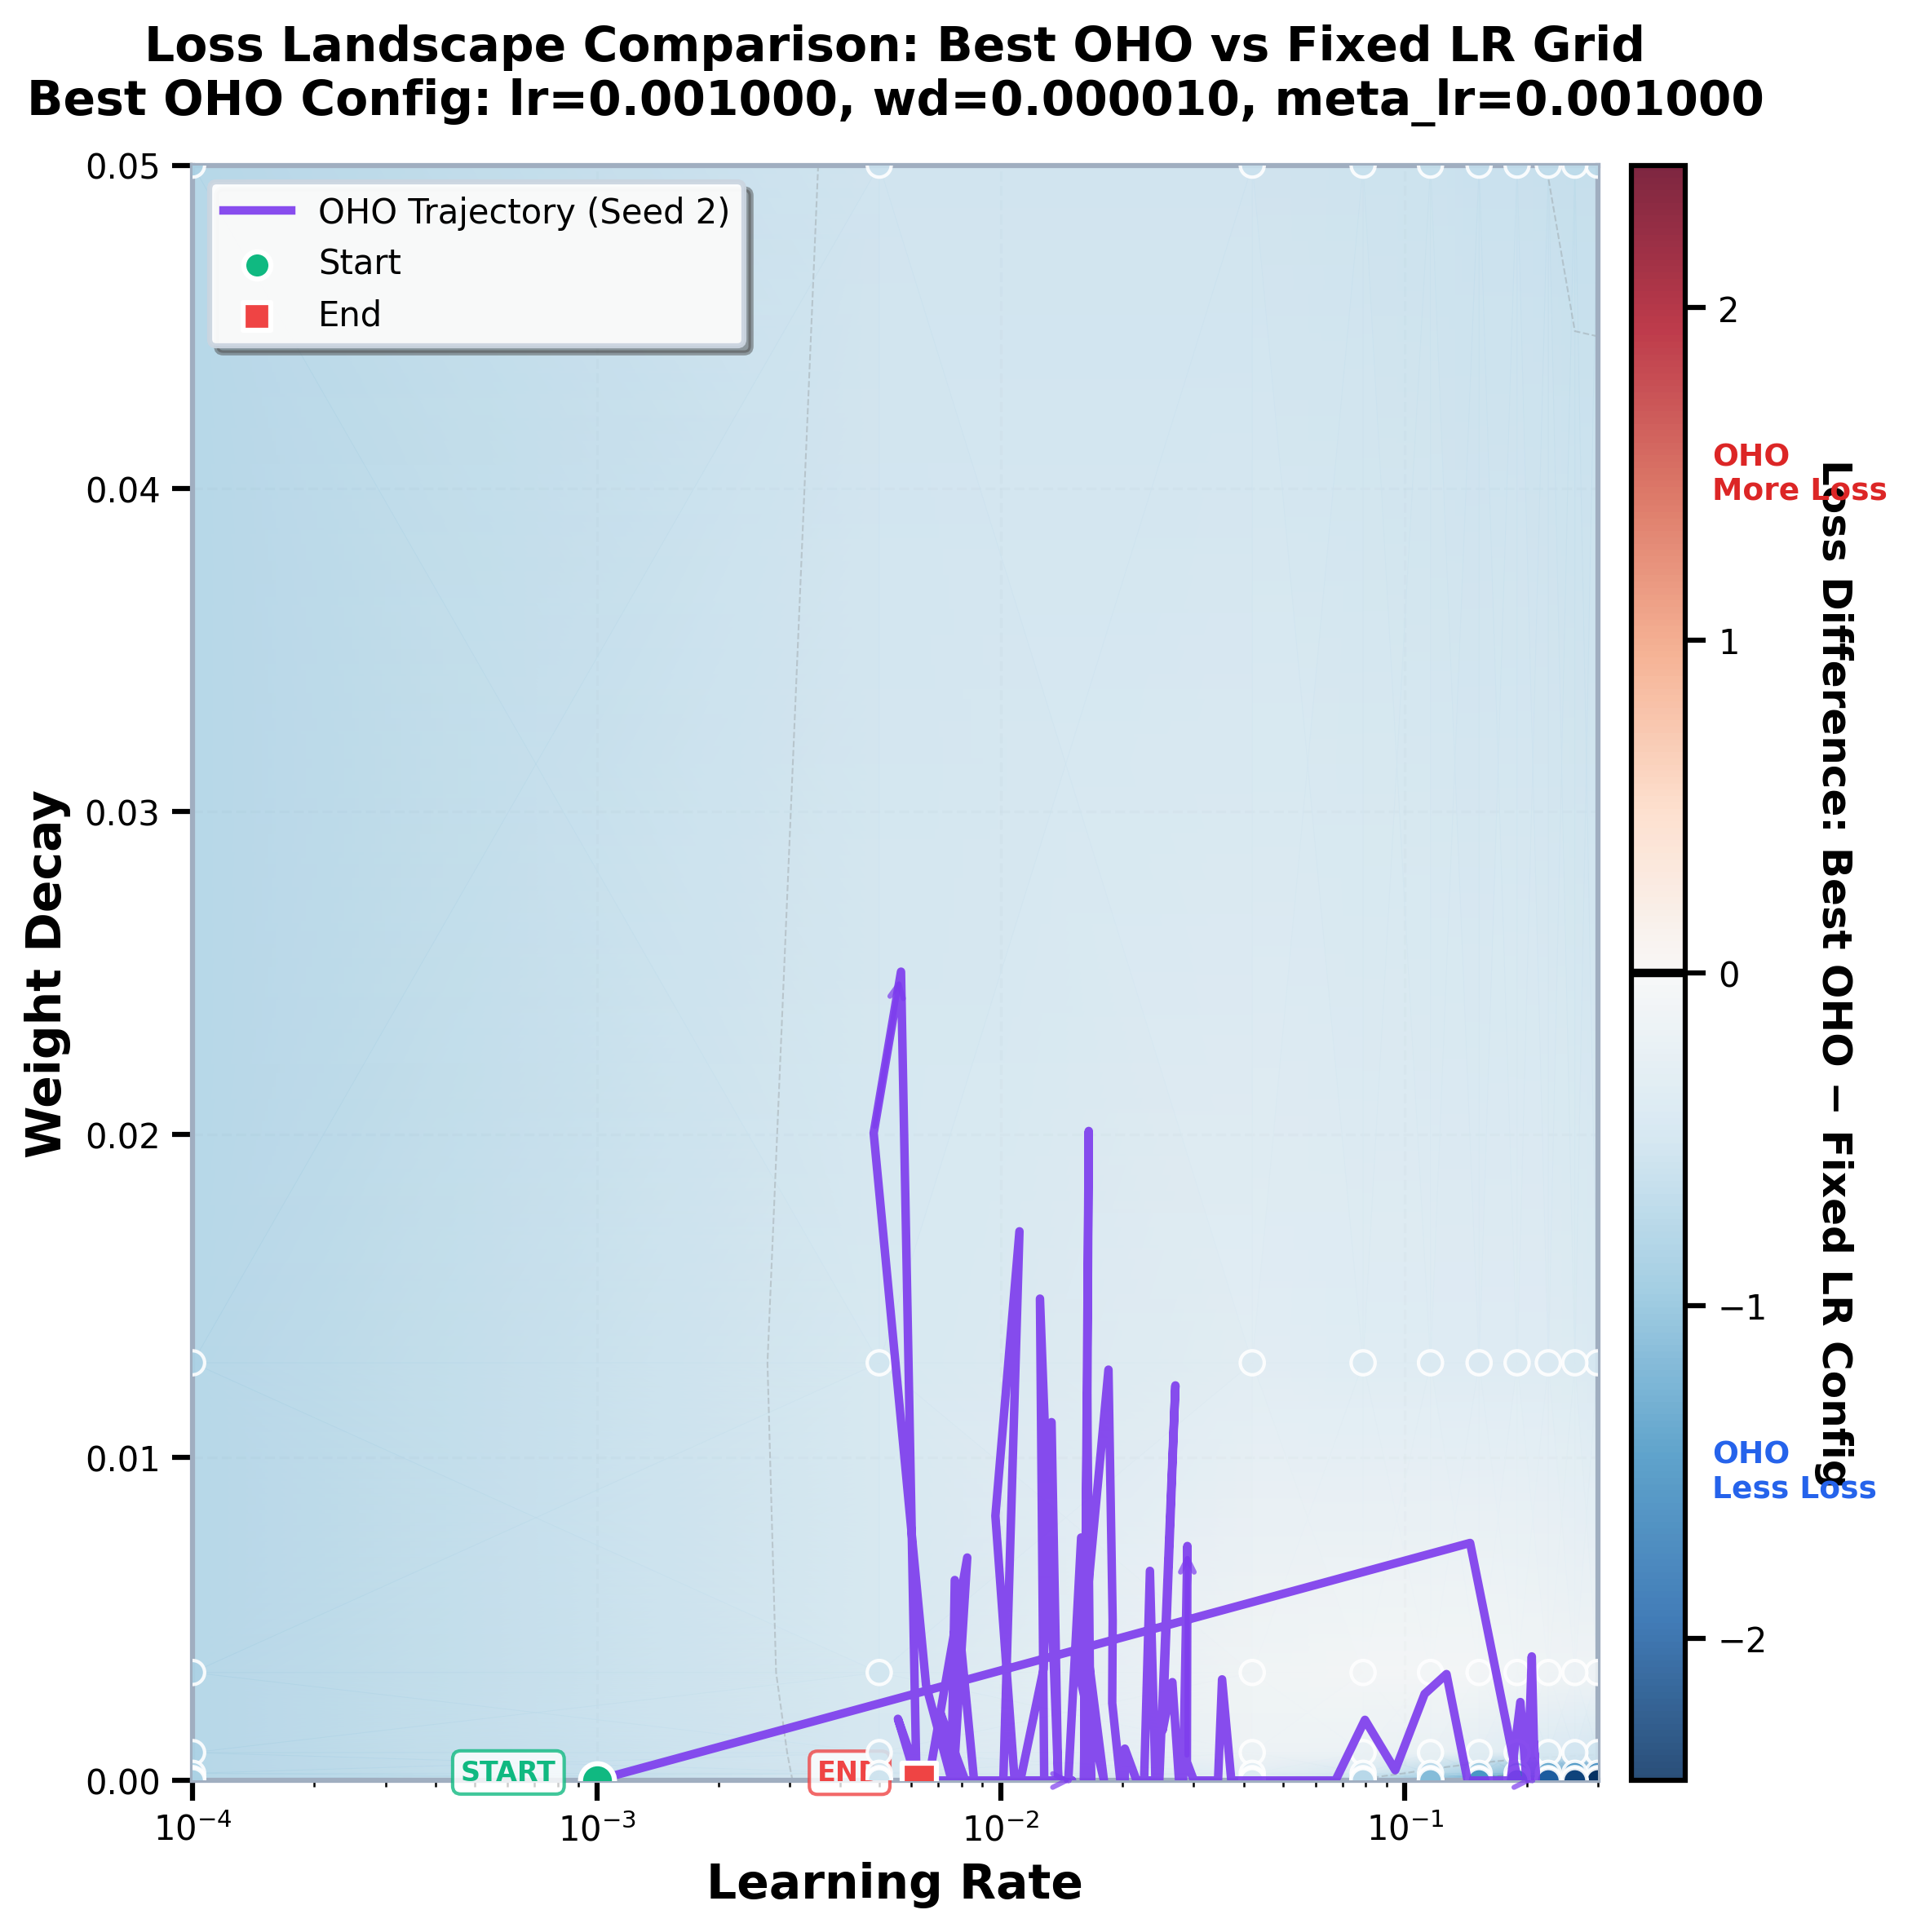


Plot saved to: loss_landscape_comparison_8x8.pdf
Comparison Summary:
  Fixed LR best loss: 1.557237
  OHO best loss: 1.487182
  Difference (OHO best - fixed best): -0.070054
  Configs where OHO best is better than Fixed config: 100/100


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Added pandas import
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

# === GLOBAL FIXES FOR EDITABLE PDF TEXT (Type 42) ===
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white' 


def plot_3d_loss_landscape_with_trajectory(exp1_tuple, exp2_tuple, seed=201, save_path='loss_landscape_comparison.pdf'):
    """
    Plot difference heatmap showing (OHO − Fixed LR) loss for each config,
    with trajectory of best OHO config's LR and WD over training iterations.
    Figure size is set to (8, 8) for consistency.
    
    Args:
        exp1_tuple: (name, df_metadata, df_timeseries) for Fixed LR.
        exp2_tuple: (name, df_metadata, df_timeseries) for OHO.
        seed (int): The specific seed to plot the OHO trajectory for.
        save_path (str): Path to save the editable PDF output.
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1 (Fixed LR): {name1}...")
    
    # For exp1: group by LR and weight decay
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    if len(available_cols1) < 2:
        print(f"Error: Need both learning rate and weight decay columns")
        print(f"Available columns: {available_cols1}")
        return
    
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
    config_summary1 = config_summary1.reset_index()
    
    print(f"  Found {len(config_summary1)} unique configs in experiment 1")
    
    # Ensure LRs and WDs are numeric for grid construction
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"  LR range: {lrs.min():.6f} to {lrs.max():.6f}")
    print(f"  WD range: {wds.min():.6f} to {wds.max():.6f}")
    print(f"  Loss range: {losses.min():.6f} to {losses.max():.6f}")
    
    print(f"\nProcessing experiment 2 (OHO): {name2}...")
    
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    available_cols2 = [col for col in config_cols2 if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    lr0 = float(best_config2['config/learners/0/optimizer/learning_rate/value'])
    lr_meta = float(best_config2['config/learners/1/optimizer/learning_rate/value'])
    wd = float(best_config2['config/learners/0/optimizer/weight_decay/value'])
    config_str2 = f"lr={lr0:.6f}, wd={wd:.6f}, meta_lr={lr_meta:.6f}"
    
    print(f"  Best config 2 (OHO): {config_str2}")
    print(f"  Best mean final test loss: {best_loss2:.6f}")
    
    # Get trajectory
    print(f"\nGetting trajectory for seed {seed} with best {name2} config...")
    mask_meta = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        if col in df_metadata2.columns:
            mask_meta &= (df_metadata2[col] == best_config2[col])
    
    # Ensure seed comparison works regardless of type
    seed_value_str = str(seed)
    mask_meta &= ((df_metadata2['config/seed/global_seed'] == seed) |
                  (df_metadata2['config/seed/global_seed'] == seed_value_str))
    
    best_metadata = df_metadata2[mask_meta][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    trajectory_lr, trajectory_wd = None, None
    if len(best_metadata) > 0:
        task_id = best_metadata['task_id'].values[0]
        print(f"  Found task {task_id} for seed {seed}")
        
        task_data = df_timeseries2[df_timeseries2['task_id'] == task_id].compute()
        task_data = task_data.sort_values('iteration')
        
        lr_col = 'metric/train_recurrent_learning_rate'
        wd_col = 'metric/train_recurrent_weight_decay'
        
        if lr_col in task_data.columns and wd_col in task_data.columns:
            trajectory_lr = task_data[lr_col].values
            trajectory_wd = task_data[wd_col].values
            valid_mask = ~(np.isnan(trajectory_lr) | np.isnan(trajectory_wd))
            trajectory_lr = trajectory_lr[valid_mask]
            trajectory_wd = trajectory_wd[valid_mask]
            print(f"  Trajectory: {len(trajectory_lr)} points")
        else:
            print(f"  Warning: Could not find trajectory columns")
    else:
        print(f"  Warning: No data found for seed {seed} with best config")
    
    # Calculate differences (OHO − Fixed)
    loss_differences = best_loss2 - losses
    
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                # Diff_grid[j, i] = (OHO_best_loss) - (Fixed_loss_at_config)
                # Note: The original code calculated this difference before the loop:
                # loss_differences = best_loss2 - losses 
                # If loss_differences is used here, the final colorbar label needs to reflect the current definition.
                # Original Cbar Label was: f'Loss Difference\n({name2} − {name1})', which is (OHO − Fixed)
                # But the code used: loss_differences = best_loss2 - losses, which is (OHO best - Fixed loss)
                # I will stick to the original calculation (best OHO - Fixed loss at config) and adjust the colorbar description for clarity.
                Diff_grid[j, i] = loss_differences[mask][0]
    
    # Plot setup
    plt.rcParams['figure.dpi'] = 300 # Keep high resolution for rendering
    plt.rcParams['font.size'] = 10 # Scaled down for 8x8
    
    # --- FIXED: Use consistent figure size (8, 8) ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#FAFAFA')
    
    cmap = 'RdBu_r'  # Red=Worse for OHO (Positive difference), Blue=Better for OHO (Negative difference)
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    
    im = ax.pcolormesh(LR_grid, WD_grid, Diff_grid, cmap=cmap, shading='gouraud',
                       vmin=-max_abs_diff, vmax=max_abs_diff, alpha=0.85)
    
    # Contour lines
    contour_levels = np.linspace(-max_abs_diff, max_abs_diff, 9)
    ax.contour(LR_grid, WD_grid, Diff_grid, levels=contour_levels,
               colors='gray', linewidths=0.5, alpha=0.3)
    
    # Zero contour (separates where OHO best is better/worse than Fixed config)
    zero_contour = ax.contour(LR_grid, WD_grid, Diff_grid, levels=[0],
                              colors='black', linewidths=1.5, linestyles='-', alpha=0.7)
    ax.clabel(zero_contour, inline=True, fontsize=8, fmt='Equal') # Scaled font size
    
    # Scatter points
    ax.scatter(lrs, wds, c=loss_differences, cmap=cmap, s=50, edgecolors='white', # Scaled marker size
               linewidths=1.0, vmin=-max_abs_diff, vmax=max_abs_diff, zorder=5, alpha=0.9)
    
    # Trajectory line
    if trajectory_lr is not None and trajectory_wd is not None:
        # Simplify trajectory line for smaller plot
        idx = np.linspace(0, len(trajectory_lr)-1, min(len(trajectory_lr), 100), dtype=int)
        traj_lr_plot, traj_wd_plot = trajectory_lr[idx], trajectory_wd[idx]
        
        ax.plot(traj_lr_plot, traj_wd_plot, color='#7C3AED', linewidth=2.5, # Scaled line width
                zorder=15, alpha=0.9, linestyle='-', label=f'OHO Trajectory (Seed {seed})')
        
        # Arrows
        n_arrows = 4 # Fewer arrows
        arrow_indices = np.linspace(5, len(traj_lr_plot)-5, n_arrows, dtype=int)
        for idx in arrow_indices:
            if idx < len(traj_lr_plot) - 1:
                ax.annotate('', xy=(traj_lr_plot[idx+1], traj_wd_plot[idx+1]),
                            xytext=(traj_lr_plot[idx], traj_wd_plot[idx]),
                            arrowprops=dict(arrowstyle='->', color='#7C3AED', lw=1.5, alpha=0.7)) # Scaled line width
        
        # Start/end points
        ax.scatter(traj_lr_plot[0], traj_wd_plot[0], s=100, c='#10B981', marker='o', # Scaled marker size
                   edgecolors='white', linewidths=1.5, zorder=20, label='Start', alpha=1)
        ax.scatter(traj_lr_plot[-1], traj_wd_plot[-1], s=100, c='#EF4444', marker='s', # Scaled marker size
                   edgecolors='white', linewidths=1.5, zorder=20, label='End', alpha=1)
        
        # Annotation boxes (scaled font)
        ax.annotate('START', xy=(traj_lr_plot[0], traj_wd_plot[0]), xytext=(-40, 0),
                    textcoords='offset points', fontsize=8, fontweight='bold', color='#10B981',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#10B981', linewidth=1, alpha=0.8))
        ax.annotate('END', xy=(traj_lr_plot[-1], traj_wd_plot[-1]), xytext=(-30, 0),
                    textcoords='offset points', fontsize=8, fontweight='bold', color='#EF4444',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#EF4444', linewidth=1, alpha=0.8))
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
    # Corrected label to reflect the actual difference calculated (OHO best - Fixed config)
    cbar.set_label(f'Loss Difference: Best {name2} − {name1} Config',
                   fontsize=12, rotation=270, labelpad=25, fontweight='bold') # Scaled font size
    cbar.ax.axhline(y=0, color='black', linewidth=2.5)
    
    # Cbar Labels (scaled font)
    max_label = np.nanmax(np.abs(cbar.ax.get_yticks()))
    cbar.ax.text(1.5, max_label * 0.5, f'{name2}\nMore Loss', fontsize=9, ha='left', va='center', # Scaled font size
                 fontweight='bold', color='#DC2626')
    cbar.ax.text(1.5, -max_label * 0.5, f'{name2}\nLess Loss', fontsize=9, ha='left', va='center', # Scaled font size
                 fontweight='bold', color='#2563EB')
    
    # Labels and title (scaled font)
    ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weight Decay', fontsize=14, fontweight='bold')
    title = f'Loss Landscape Comparison: Best {name2} vs {name1} Grid\n'
    title += f'Best {name2} Config: {config_str2}'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Log scales
    if lrs.min() > 0 and lrs.max() / lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max() / wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8, color='gray')
    ax.set_axisbelow(True)
    
    if trajectory_lr is not None:
        legend = ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True, # Scaled font size
                           framealpha=0.95, edgecolor='#CBD5E0', facecolor='white', markerscale=0.8)
        legend.get_frame().set_linewidth(1.5)
    
    # Spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#A0AEC0')
    
    plt.tight_layout()
    
    # --- FIXED PDF SAVING ---
    fig.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"\nPlot saved to: {save_path}")
    print(f"Comparison Summary:")
    print(f"  {name1} best loss: {losses.min():.6f}")
    print(f"  {name2} best loss: {best_loss2:.6f}")
    print(f"  Difference (OHO best - fixed best): {best_loss2 - losses.min():.6f}")
    print(f"  Configs where OHO best is better than Fixed config: {np.sum(loss_differences < 0)}/{len(loss_differences)}")
    
    return fig


# Example usage:
fig = plot_3d_loss_landscape_with_trajectory(
    experiments[0], 
    experiments[1], 
    seed=2,
    save_path='loss_landscape_comparison_8x8.pdf'
)